

**Problem Statement:**

The goal is to build and evaluate econometric models (e.g., ARIMA, GARCH, VAR) and machine learning models (e.g., XGBoost, LSTM, Random Forest) for predicting the prices of precious metals, specifically gold, silver, and crude oil. After evaluating the performance of these models, Code will automatically select best performing mofles  for hybrid model creation to enhance predictive accuracy for these commodities.

The study will leverage market data, including interest rates, inflation rates, GDP, GDP-to-debt ratios, ETF prices, and both historical and live sentiment data from news feeds. While this framework can be adapted for modeling any precious metal, the current focus will be on these three commodities.

**This study will provide  a unified hybrid framework that adapts to any commodity type and automatically selects and combines the best models accordingly.**

Below Code will train and genertae model based on histrical data.

Input : Commodity Name (GOLD or SILVER or CRUDE_OIL)

Output : Save best hybrid model for realtime prediction

##### Sourcing Key Libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import os
import itertools
import requests
import yfinance as yf
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
#from arch import arch_model
from transformers import pipeline
#from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Define constant Variables

In [2]:
# constant values
# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'
# API Key for Alpha Vantage (Replace with your actual key)
API_KEY_alpha = "3J4EGZCB0D7UT9WG"
# genertae your APi key from here: https://www.alphavantage.co/

#update the below code for any new precious Metal

data_ticker_map = {
            'GOLD' : 'GC=F',
            'SILVER': 'SI=F',
            'CRUDE_OIL': 'CL=F'}

data_file_mapping = {
            'GOLD' : 'Data/Historical_Gold_data_April.csv',
           'SILVER': 'Data/Historical_Silver_data_April.csv',
           'CRUDE_OIL': 'Data/Historical_Crude_oil_data_April.csv',}

Live_Sentiments_file_name = 'Live_Sentiments.csv'
Live_Sentiments_file_dir = 'Sentiments'
Historical_Sentiments_file_name = 'Historical_Sentiments.csv'
Historical_Sentiments_file_dir = 'Sentiments'

best_models_dir = {'GOLD': 'Models/GOLD_MODELS', 'SILVER' : 'Models/SILVER_MODELS', 'CRUDE_OIL': 'Models/CRUDE_OIL_MODELS'}
hybrid_models_dir = {'GOLD': 'Models/GOLD_HYBRID_MODELS', 'SILVER' : 'Models/SILVER_HYBRID_MODELS', 'CRUDE_OIL': 'Models/CRUDE_OIL_HYBRID_MODELS'}
hybrid_meta_models_dir = {'GOLD': 'Models/GOLD_HYBRID_MODELS/Meta', 'SILVER' : 'Models/SILVER_HYBRID_MODELS/Meta', 'CRUDE_OIL': 'Models/CRUDE_OIL_HYBRID_MODELS/Meta'}

### Enter Commodity Name for which you want to predict Price EX: GOLD, SILVER, CRUDE OIL etc

In [3]:
commodity = input('Enter the Commodity Name')
filename =  data_file_mapping.get(commodity)

Enter the Commodity Name SILVER


## Step 1 : Data Sourcing

### Step 1.1: Historical Data Sourcing

##### Yahoo finance is not reliable and having issues, download data from 2003-01-01 - 2025-03-15 via yf api.

##### Define function to download Historical data 

In [4]:
# Function to download historical price data
def download_price_data(ticker, start='2020-01-01', end='2025-04-05'):
    # Download the data
    data = yf.download(ticker, start=start, end=end)
    
    # Reset index to turn 'Date' into a regular column
    data.reset_index(inplace=True)
    
    # Flatten the columns if there are multiple levels
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    
    # Select necessary columns only
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Load or download data for each commodity
def load_or_download_data(ticker, filename):
    if os.path.exists(filename):
        # Read the CSV, treating the first row as the header
        data = pd.read_csv(filename, header=0)
        
        # Convert 'Date' column to datetime format, and handle parsing errors
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        
        # Remove any rows where 'Date' could not be parsed and resulted in NaT
        data = data.dropna(subset=['Date'])
    else:
        # Download the data
        data = download_price_data(ticker)
        
        # Save to CSV with a single header row
        data.to_csv(filename, index=False)
    
    # Ensure the 'Close' column is numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    return data


In [5]:
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')
commodity_data = load_or_download_data(ticker, filename)

Loading from Historical file id Data available in file : Data/Historical_Silver_data_April.csv
Ticker code for SILVER : SI=F


In [6]:
commodity_data

,Date,Open,High,Low,Close,Volume
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31
...,...,...,...,...,...,...
1318,2025-03-31,34.759998,35.000000,34.400002,34.457001,97
1319,2025-04-01,34.599998,34.665001,34.158001,34.158001,97
1320,2025-04-02,34.499001,34.855000,34.499001,34.499001,558
1321,2025-04-03,34.134998,34.134998,31.625000,31.844000,63


### 1.2 Sourcing Market data

#### 1.2.1 GDP data

##### Define function which will convert Yearly GDP data to daily GDP data

In [7]:
def expand_gdp_to_daily(gdp_df):
    daily_gdp = []
    for index, row in gdp_df.iterrows():
        month_start = row['Date']
        value = row['Value']
        month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(0), freq='D')
        for day in month_days:
            daily_gdp.append({'Date': day, 'Value': value})
    return pd.DataFrame(daily_gdp)


def preprocess_gdp_data(gdp_data):
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    return expand_gdp_to_daily(gdp_data)


def fetch_world_bank_data(indicator, country='USA', start_year='2003', end_year='2024'):
    url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json'
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2 or 'message' in data[1]:
            print("No data found for the specified parameters.")
            return None
        df = pd.json_normalize(data[1])
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]
        df = df[['date', 'value']]
        df.columns = ['Date', 'Value']
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


In [8]:
############### sourcing world GDP data #################################################
gdp_data = fetch_world_bank_data('NY.GDP.MKTP.CD', country='USA', start_year='2003', end_year='2024')
daily_gdp_data = preprocess_gdp_data(gdp_data)
daily_gdp_data.rename(columns={'Value':'GDP'},inplace=True)
daily_gdp_data

,Date,GDP
0,2023-01-01,27720709000000
1,2023-01-02,27720709000000
2,2023-01-03,27720709000000
3,2023-01-04,27720709000000
4,2023-01-05,27720709000000
...,...,...
646,2003-01-27,11456450000000
647,2003-01-28,11456450000000
648,2003-01-29,11456450000000
649,2003-01-30,11456450000000


#### 1.2.2 Interest rate data

In [9]:

############## Sourcing Interest rate data ################################
from fredapi import Fred

# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'

# Initialize the FRED API
fred = Fred(api_key=api_key)

# Fetch the Federal Funds Rate data (you can change this to any other indicator)
# Federal Funds Rate is often identified by the FRED ID 'FEDFUNDS'
interest_rate_data = fred.get_series('FEDFUNDS' ,start_date='2003-01-01')

# Convert the data into a DataFrame for better handling
interest_rate_df = pd.DataFrame(interest_rate_data)
interest_rate_df.columns = ['Interest_rates']

# Reset the index to have 'Date' as a column
interest_rate_df.reset_index(inplace=True)

import pandas as pd

# Assuming `interest_rate_df` already exists with 'Date' and 'Interest_rates' columns

# Convert 'Date' column to datetime format if it’s not already
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['index'])
interest_rate_df.drop(columns=['index'], inplace=True)  # Drop the old index column if needed

# Create a date range for every day from the start to the end of the interest rate data
start_date = interest_rate_df['Date'].min()
end_date = interest_rate_df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_interest_rate_df = pd.DataFrame({'date': date_range})

# Add a 'month' and 'year' column to `interest_rate_df` for easy merging
interest_rate_df['year'] = interest_rate_df['Date'].dt.year
interest_rate_df['month'] = interest_rate_df['Date'].dt.month

# Merge monthly data with daily data on matching 'year' and 'month'
daily_interest_rate_df['year'] = daily_interest_rate_df['date'].dt.year
daily_interest_rate_df['month'] = daily_interest_rate_df['date'].dt.month

# Perform a left join on 'year' and 'month' columns
daily_interest_rate_df = daily_interest_rate_df.merge(
    interest_rate_df[['year', 'month', 'Interest_rates']],
    on=['year', 'month'],
    how='left'
)

# Drop the extra columns, keep only 'date' and 'Interest_rates'
daily_interest_rate_data = daily_interest_rate_df[['date', 'Interest_rates']]
daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)
daily_interest_rate_data


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23636\1493415932.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)


,Date,Interest_rates
0,1954-07-01,0.80
1,1954-07-02,0.80
2,1954-07-03,0.80
3,1954-07-04,0.80
4,1954-07-05,0.80
...,...,...
25807,2025-02-25,4.33
25808,2025-02-26,4.33
25809,2025-02-27,4.33
25810,2025-02-28,4.33


#### 1.2.3 GDP to Debt data

In [10]:
################## GDP to Debt DATA ###############################
import wbdata
import pandas as pd
import datetime

# Set the start and end dates for the data
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# List of indicators to retrieve (Government Debt to GDP ratio)
indicators = {'GC.DOD.TOTL.GD.ZS': 'Government Debt to GDP'}

# Fetch data from the World Bank API for the USA
government_debt_data = wbdata.get_dataframe(indicators, country='USA')

# Fill missing values in `Government Debt to GDP` with 0
government_debt_data['Government Debt to GDP'] = government_debt_data['Government Debt to GDP'].fillna(0)

# Reset index to make `date` a regular column and convert it to datetime
government_debt_data.reset_index(inplace=True)
government_debt_data['date'] = pd.to_datetime(government_debt_data['date'])

# Add a 'year' column to `government_debt_data` to help with mapping
government_debt_data['year'] = government_debt_data['date'].dt.year

# Create a dictionary for quick lookup of Debt to GDP per year
debt_to_gdp_dict = government_debt_data.set_index('year')['Government Debt to GDP'].to_dict()

# Create a date range for every day from the start to the end date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_debt_data = pd.DataFrame({'date': date_range})

# Map each date in `daily_debt_data` to the corresponding Debt to GDP value for that year
daily_debt_data['DebtToGDP'] = daily_debt_data['date'].dt.year.map(debt_to_gdp_dict)
daily_debt_data.rename(columns={'date':'Date'},inplace=True)

daily_debt_data

,Date,DebtToGDP
0,2000-01-01,33.267642
1,2000-01-02,33.267642
2,2000-01-03,33.267642
3,2000-01-04,33.267642
4,2000-01-05,33.267642
...,...,...
8397,2022-12-28,110.385332
8398,2022-12-29,110.385332
8399,2022-12-30,110.385332
8400,2022-12-31,110.385332


#### 1.2.4 Inflation data

In [11]:
############## inflation data #################
# Get historical CPI data (Consumer Price Index) to calculate inflation
cpi_data = fred.get_series('CPIAUCSL', start_date='2003-01-01')



# Convert the data into a DataFrame for better handling
Inflation_data = pd.DataFrame(interest_rate_data)
Inflation_data.columns = ['Inflation_rate']

# Reset the index to have 'Date' as a column
Inflation_data.reset_index(inplace=True)
Inflation_data.rename(columns={'index':'Date'},inplace=True)
# Print the first few rows
Inflation_data

,Date,Inflation_rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
844,2024-11-01,4.64
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33


#### 1.2.5 ETF data

In [12]:
################ Gold ETF data ###########################################
import requests
import pandas as pd

# Fetch ETF data from FRED API
def fetch_fred_etf_data(series_id, api_key, start_date='2003-01-01', end_date='2024-11-01'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'
    response = requests.get(url)
    data = response.json()
    
    # Print the entire JSON response for inspection
    print("Full JSON response:", data)
    
    # Check for errors in the JSON response
    if "observations" not in data:
        print("Error: 'observations' key not found in the response. Check the series ID or API request.")
        return None
    
    # Parse JSON data into a DataFrame
    etf_df = pd.DataFrame(data['observations'])
    etf_df['Date'] = pd.to_datetime(etf_df['date'])
    etf_df['Date'] = etf_df['Date'].dt.tz_localize(None).dt.date 
    etf_df['value'] = pd.to_numeric(etf_df['value'], errors='coerce')
    etf_df.set_index('Date', inplace=True)
    
    return etf_df

# Example usage
api_key = 'a27b910873da479a5561ea08035a6c79'
series_id = 'INTDSRUSM193N'  # Replace with a valid series ID from FRED
etf_data = fetch_fred_etf_data(series_id, api_key)


etf_data.rename(columns={'value':'ETF_Value'},inplace=True)
# Only print if data retrieval was successful
if etf_data is not None:
    print(etf_data.head())

Full JSON response: {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'observation_start': '2003-01-01', 'observation_end': '2024-11-01', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 224, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-01-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-02-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-03-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-04-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-05-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-06-01', 'value': '2'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'd

#### Step 1.3 : Sourcing Sentiment Data and Apply BERT

#### Sourcing Live Sentiments

In [13]:
import requests
import pandas as pd
from transformers import pipeline
from datetime import datetime, timedelta
#reading live sentiments
# API KEY: https://newsapi.org/register/success

# Function to fetch news from NewsAPI (replace with your API key)
API_KEY = "ca5eb0d931a345609fc85ed9affd48d5"
NEWS_API_URL = "https://newsapi.org/v2/everything"

def fetch_news(query, language="en", page_size=100):
    params = {
        "q": query,
        "language": language,
        "apiKey": API_KEY,
        "pageSize": page_size,
    }
    response = requests.get(NEWS_API_URL, params=params)
    data = response.json()
    
    if data.get("status") == "ok":
        articles = data.get("articles", [])
        return [(article["publishedAt"], article["title"]) for article in articles]
    else:
        print("Error fetching news:", data)
        return []

# Function to analyze sentiment using FinBERT
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")
#sentiment_pipeline = pipeline('sentiment-analysis',  model="google-bert/bert-base-uncased")

def analyze_sentiment(texts):
    sentiments = sentiment_pipeline(texts, truncation=True)
    return [sent["label"] for sent in sentiments]

# Fetch and analyze news sentiment
def get_gold_sentiment():
    news_data = fetch_news(commodity)
    
    if not news_data:
        return pd.DataFrame()
    
    df = pd.DataFrame(news_data, columns=["Date", "Headline"])
    df["Sentiment"] = analyze_sentiment(df["Headline"].tolist())
    df.to_csv("gold_sentiment_data.csv", index=False)
    return df



#### Apply Sentiment analysis on Live data and save them in disk

In [14]:
# Save the new data
import os
Live_Sentiments_file = os.path.join(Live_Sentiments_file_dir, commodity.upper(), Live_Sentiments_file_name)
if os.path.exists(Live_Sentiments_file):
        sentiment_df =  pd.read_csv(Live_Sentiments_file)  # File does not exist
else:
    # Fetch sentiment data
    sentiment_df = get_gold_sentiment()
    sentiment_df.to_csv(Live_Sentiments_file, index=False)
print(sentiment_df.head())
sentiment_df['Sentiment_score'] = sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
print(sentiment_df.head())

# Add sentiment data back to the news_df
sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
live_sentiments_df = sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
# # Print out the resulting dataframe
# print(news_df[['Date', 'Title', 'Sentiment']].head())

# Convert Date column to datetime and add a range of days around each event
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])



live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'], errors='coerce')
live_sentiments_df['Date'] = live_sentiments_df['Date'].dt.tz_localize(None).dt.date 
live_sentiments_df.head()

                   Date                                           Headline  \
0  2025-03-23T14:30:36Z  Hazelight’s Split Fiction Could Go From Game t...   
1  2025-03-20T12:35:12Z  Netanyahu Gives John Fetterman Silver-Plated P...   
2  2025-03-27T15:22:59Z  Pokémon Legends: Z-A’s gameplay will change de...   
3  2025-04-03T23:34:34Z  New Footage From The Fantastic Four: First Ste...   
4  2025-03-21T19:21:58Z  Texas Measles Outbreak Expected to Last for Mo...   

  Sentiment  
0   neutral  
1   neutral  
2   neutral  
3   neutral  
4  positive  
                   Date                                           Headline  \
0  2025-03-23T14:30:36Z  Hazelight’s Split Fiction Could Go From Game t...   
1  2025-03-20T12:35:12Z  Netanyahu Gives John Fetterman Silver-Plated P...   
2  2025-03-27T15:22:59Z  Pokémon Legends: Z-A’s gameplay will change de...   
3  2025-04-03T23:34:34Z  New Footage From The Fantastic Four: First Ste...   
4  2025-03-21T19:21:58Z  Texas Measles Outbreak Expected 

,Date,Headline,Sentiment,Sentiment_score
0,2025-03-23,Hazelight’s Split Fiction Could Go From Game t...,neutral,0
1,2025-03-20,Netanyahu Gives John Fetterman Silver-Plated P...,neutral,0
2,2025-03-27,Pokémon Legends: Z-A’s gameplay will change de...,neutral,0
3,2025-04-03,New Footage From The Fantastic Four: First Ste...,neutral,0
4,2025-03-21,Texas Measles Outbreak Expected to Last for Mo...,positive,1


#### Load Historical Sentiment data

In [15]:
Historical_Sentiments_file = os.path.join(Historical_Sentiments_file_dir, commodity.upper(), Historical_Sentiments_file_name)
#Detect Invalid Dates
def is_invalid_date(date_str):
    try:
        pd.to_datetime(date_str, format="%d-%m-%Y", errors="raise")
        return False  # Valid date
    except:
        return True   # Invalid date



if os.path.exists(Historical_Sentiments_file) and commodity.upper()=="GOLD":
        historical_news_df =  pd.read_csv(Historical_Sentiments_file)  # File does not exist
        print(historical_news_df)
elif commodity.upper()=="GOLD" :
    # Fetch sentiment data
    historical_sentiment_data = pd.read_csv("C:/Users/Lenovo/OneDrive/Desktop/War/code/data/gold_historical_sentiments.csv", usecols=["Dates","Price Sentiment", "News"])
    historical_sentiment_data = historical_sentiment_data[~historical_sentiment_data["Dates"].astype(str).apply(is_invalid_date)]
    
    
    # Add sentiment data back to the news_df
    # # Print out the resulting dataframe
    # print(news_df[['Date', 'Title', 'Sentiment']].head())
    historical_news_df = historical_sentiment_data[['Dates', 'News', 'Price Sentiment', 'Sentiment_score']]
    historical_news_df.rename(columns = {'News':'Headline', 'Dates':'Date', 'Price Sentiment':'Sentiment'}, inplace = True)
    
    # Convert Date column to datetime and add a range of days around each event
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'], errors='coerce')
    historical_news_df['Date'] = historical_news_df['Date'].dt.tz_localize(None).dt.date 

    historical_news_df = historical_news_df[['Date','Headline']]
    historical_news_df["Sentiment_score"] = analyze_sentiment(historical_news_df["Headline"].tolist(), batch_size=16)
    historical_news_df['Sentiment_score'] = historical_news_df['Sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
    historical_news_df.to_csv(Historical_Sentiments_file, index=False)
else:
    historical_news_df=live_sentiments_df




## Step 2 : Data Preprocessing and Cleaning

### 2.1 Null Value Treatment

In [16]:
for data in [commodity_data]:
    data.dropna(subset=['Date', 'Close'], inplace=True)

### 2.2 Converting Values to Datetime format

In [17]:
# COnvert into date format
# Historical Data
# Convert Date column in gold_data to remove timezone
commodity_data['Date'] = commodity_data['Date'].dt.tz_localize(None).dt.date 

# Market Economic Data
daily_gdp_data['Date'] = daily_gdp_data['Date'].dt.tz_localize(None).dt.date 
interest_rate_df['Date'] = interest_rate_df['Date'].dt.tz_localize(None).dt.date 
Inflation_data['Date'] = Inflation_data['Date'].dt.tz_localize(None).dt.date 
daily_debt_data['Date'] = daily_debt_data['Date'].dt.tz_localize(None).dt.date 

### 2.3 Merging all source data to final data frame

In [18]:
# Merge all dataframes on 'Date' with 'gold_data' as the base (left join)
merged_data = commodity_data.merge(daily_gdp_data, on='Date', how='left') \
                       .merge(interest_rate_df, on='Date', how='left') \
                       .merge(Inflation_data, on='Date', how='left') \
                       .merge(daily_debt_data, on='Date', how='left') \
                        .merge(etf_data[['ETF_Value']], on='Date', how='left')

merged_data.drop(columns=['year','month'],inplace=True)

In [19]:
merged_data.info()
# Print summary of missing values after imputation
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1323 non-null   object 
 1   Open            1323 non-null   float64
 2   High            1323 non-null   float64
 3   Low             1323 non-null   float64
 4   Close           1323 non-null   float64
 5   Volume          1323 non-null   int64  
 6   GDP             80 non-null     float64
 7   Interest_rates  41 non-null     float64
 8   Inflation_rate  41 non-null     float64
 9   DebtToGDP       756 non-null    float64
 10  ETF_Value       12 non-null     float64
dtypes: float64(9), int64(1), object(1)
memory usage: 113.8+ KB
Date                 0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
GDP               1243
Interest_rates    1282
Inflation_rate    1282
DebtToGDP          567
ETF_Value     

### 2.4 Processing NULL values from merged data

In [20]:

# Convert numeric columns from object type to float (if needed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

# 🔹 Handle Financial Market Data (Time-series features)
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)

# 🔹 Handle Volume (Typically Skewed, Use Median)
merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)

# 🔹 Handle Economic Indicators (Use Mean or Interpolation)
econ_cols = ["GDP", "DebtToGDP", "Interest_rates", "Inflation_rate", "ETF_Value"]
for col in econ_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)  # Mean Imputation


# Print summary of missing values after imputation
print(merged_data.isnull().sum())

commodity_data=merged_data

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GDP               0
Interest_rates    0
Inflation_rate    0
DebtToGDP         0
ETF_Value         0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23636\962026131.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23636\962026131.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Te

### 2.5 Outlier Treatment

In [21]:

# Function to identify and remove outliers using IQR
def identify_outliers(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to float, set errors to NaN
    df = df.dropna(subset=['Close'])  # Drop rows where 'Close' is NaN after conversion

    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ndf = df[(df['Close'] <= lower_bound) | (df['Close'] >= upper_bound)]
    return ndf

# Apply outlier detection to the Gold dataset
commodity_data['Close'] = pd.to_numeric(commodity_data['Close'], errors='coerce')  # Ensure 'Close' is numeric
outlier = identify_outliers(commodity_data)
outlier

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
49,2020-03-13,15.755000,15.765000,14.425000,14.456000,506,2.466163e+13,2.430732,2.430732,124.733177,0.25
50,2020-03-16,14.885000,14.885000,11.850000,12.772000,104,2.466163e+13,2.430732,2.430732,124.733177,0.25
51,2020-03-17,12.550000,12.710000,12.415000,12.469000,194,2.466163e+13,2.430732,2.430732,124.733177,0.25
52,2020-03-18,12.560000,12.825000,11.735000,11.735000,184,2.466163e+13,2.430732,2.430732,124.733177,0.25
53,2020-03-19,12.070000,12.205000,11.895000,12.097000,45,2.466163e+13,2.430732,2.430732,124.733177,0.25
...,...,...,...,...,...,...,...,...,...,...,...
1316,2025-03-27,34.896999,34.896999,34.896999,34.896999,1017,2.466163e+13,2.430732,2.430732,118.021316,0.25
1317,2025-03-28,35.264999,35.264999,34.560001,34.644001,316,2.466163e+13,2.430732,2.430732,118.021316,0.25
1318,2025-03-31,34.759998,35.000000,34.400002,34.457001,97,2.466163e+13,2.430732,2.430732,118.021316,0.25
1319,2025-04-01,34.599998,34.665001,34.158001,34.158001,97,2.466163e+13,2.430732,2.430732,118.021316,0.25


In [22]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2,2.135410e+13,2.430732,2.430732,124.733177,0.25
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83,2.135410e+13,2.430732,2.430732,124.733177,0.25
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3,2.135410e+13,2.430732,2.430732,124.733177,0.25
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33,2.135410e+13,2.430732,2.430732,124.733177,0.25
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31,2.135410e+13,2.430732,2.430732,124.733177,0.25
...,...,...,...,...,...,...,...,...,...,...,...
1318,2025-03-31,34.759998,35.000000,34.400002,34.457001,97,2.466163e+13,2.430732,2.430732,118.021316,0.25
1319,2025-04-01,34.599998,34.665001,34.158001,34.158001,97,2.466163e+13,2.430732,2.430732,118.021316,0.25
1320,2025-04-02,34.499001,34.855000,34.499001,34.499001,558,2.466163e+13,2.430732,2.430732,118.021316,0.25
1321,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.466163e+13,2.430732,2.430732,118.021316,0.25


### 2.6 Data Visulization

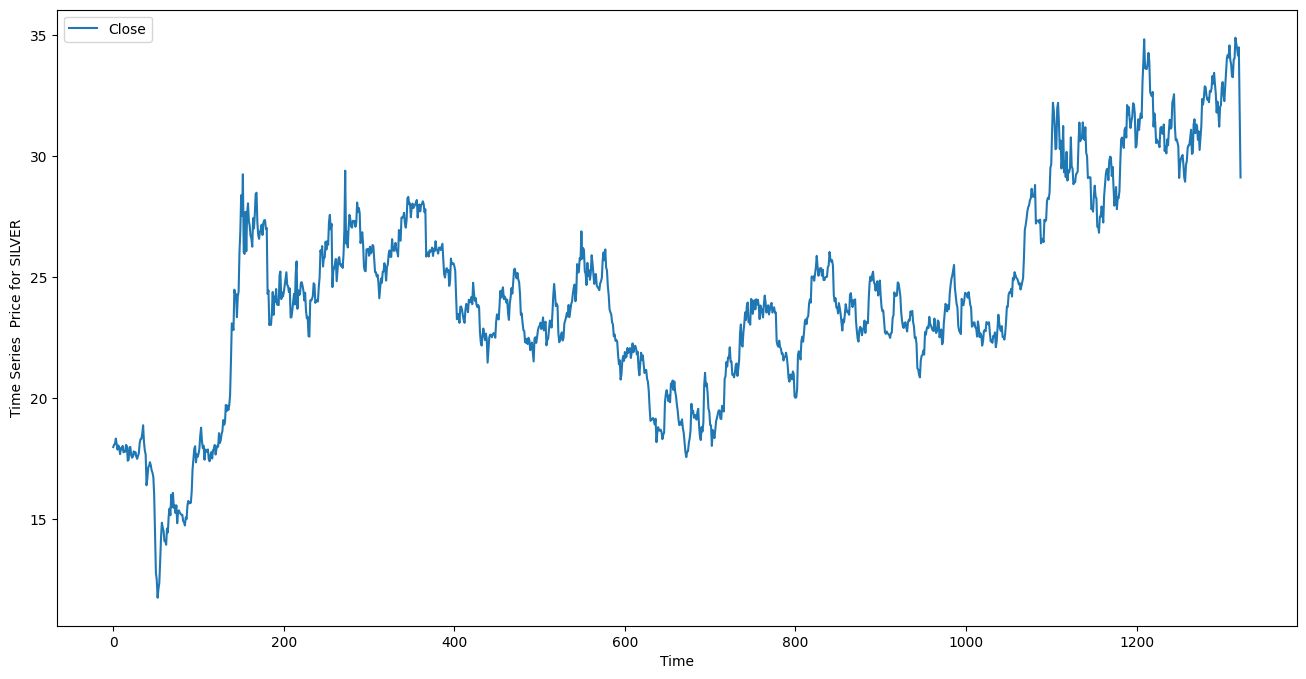

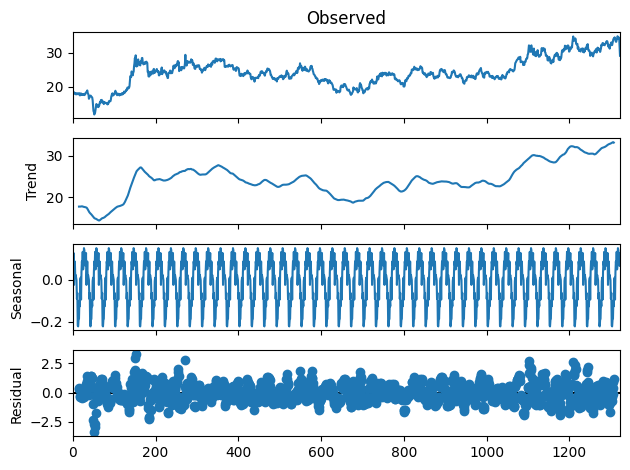

In [23]:
for commodity, data in zip([commodity,], [commodity_data,]):
    series = pd.DataFrame(data=data['Close'], columns = ['Close'] ).dropna()
    series.plot(figsize=(16,8));
    plt.ylabel(f'Time Series  Price for {commodity}')
    plt.xlabel('Time')
    result = seasonal_decompose(series.values, model = 'additive', period = 30)
    result.plot();
    plt.show()

### 2.7 Data Merging - Sentiments with Commodity Data

#### Merging Live and Histrical Sentiment data

In [24]:
live_sentiments_df = live_sentiments_df[['Date','Sentiment_score']]
historical_news_df = historical_news_df[['Date','Sentiment_score']]

In [25]:
# Convert 'Date' column to datetime format in both DataFrames
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])
historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])

# Merge the DataFrames and sort by 'Date'
sentiment_df = pd.concat([live_sentiments_df, historical_news_df], ignore_index=True).sort_values(by='Date')

# Display the first few rows
print(sentiment_df.head())


          Date  Sentiment_score
124 2025-03-13                1
111 2025-03-13                0
32  2025-03-13                1
19  2025-03-13                0
39  2025-03-15                0


In [26]:
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])

In [27]:
commodity_data.tail()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
1318,2025-03-31,34.759998,35.000000,34.400002,34.457001,97,2.466163e+13,2.430732,2.430732,118.021316,0.25
1319,2025-04-01,34.599998,34.665001,34.158001,34.158001,97,2.466163e+13,2.430732,2.430732,118.021316,0.25
1320,2025-04-02,34.499001,34.855000,34.499001,34.499001,558,2.466163e+13,2.430732,2.430732,118.021316,0.25
1321,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.466163e+13,2.430732,2.430732,118.021316,0.25
1322,2025-04-04,31.440001,31.500000,29.115999,29.115999,61,2.466163e+13,2.430732,2.430732,118.021316,0.25


### 2.8 Merging Sentiment Data with Gold Data

In [28]:
commodity_data = pd.merge(commodity_data, sentiment_df[['Date', 'Sentiment_score']], on='Date', how='left')
commodity_data.head()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN


In [29]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    98
 1.0    24
-1.0     8
Name: count, dtype: int64

### 2.9 Null Treatment post sentiment merge

In [30]:
#Interpolation – Estimate Sentiment Values Based on Nearby Data
#Good for gradual sentiment changes but may not capture sudden shifts.
commodity_data['Sentiment_score'] = sentiment_df['Sentiment_score'].interpolate(method='linear')  

commodity_data['Sentiment_score'].fillna(0, inplace=True)
# Print summary of missing values after imputation
print(commodity_data.isnull().sum())

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
GDP                0
Interest_rates     0
Inflation_rate     0
DebtToGDP          0
ETF_Value          0
Sentiment_score    0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23636\1915627315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  commodity_data['Sentiment_score'].fillna(0, inplace=True)


In [31]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    1401
 1.0      26
-1.0      10
Name: count, dtype: int64

In [32]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2,2.135410e+13,2.430732,2.430732,124.733177,0.25,0.0
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83,2.135410e+13,2.430732,2.430732,124.733177,0.25,0.0
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3,2.135410e+13,2.430732,2.430732,124.733177,0.25,0.0
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33,2.135410e+13,2.430732,2.430732,124.733177,0.25,0.0
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31,2.135410e+13,2.430732,2.430732,124.733177,0.25,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1432,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.466163e+13,2.430732,2.430732,118.021316,0.25,0.0
1433,2025-04-04,31.440001,31.500000,29.115999,29.115999,61,2.466163e+13,2.430732,2.430732,118.021316,0.25,0.0
1434,2025-04-04,31.440001,31.500000,29.115999,29.115999,61,2.466163e+13,2.430732,2.430732,118.021316,0.25,0.0
1435,2025-04-04,31.440001,31.500000,29.115999,29.115999,61,2.466163e+13,2.430732,2.430732,118.021316,0.25,0.0


## Step 3 : Feature Engineering

### 3.1 Create Features 

In [33]:
import numpy as np

def feature_engineering(df, world_bank_data=None):
    # Lagged values and moving averages
    df['lag_1'] = df['Close'].shift(1)
    df['lag_7'] = df['Close'].shift(7)
    df['lag_30'] = df['Close'].shift(30)
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    df['tomorrow_price'] = df['Close'].shift(-1)
    # Compute log returns fro GARCH
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Adding volatility features
    df['volatility_7'] = df['Close'].rolling(window=7).std()
    df['volatility_30'] = df['Close'].rolling(window=30).std()

    # #Gold prices may respond more to cumulative sentiment trends rather than individual daily sentiments. We apply a moving average to smooth fluctuations.
    # # Creating lagged sentiment features
    # df["Sentiment_Lag_1"] = df["Sentiment_score"].shift(1)
    # df["Sentiment_Lag_3"] = df["Sentiment_score"].shift(3)
    # df["Sentiment_Lag_7"] = df["Sentiment_score"].shift(7)
    # Compute rolling mean sentiment over 14-day and 30-day windows
    df["Sentiment_Rolling_14"] = df["Sentiment_score"].rolling(window=14, min_periods=1).mean()
    df["Sentiment_Rolling_30"] = df["Sentiment_score"].rolling(window=30, min_periods=1).mean()


    df.dropna(inplace=True)  # Drop NaN values after shifting and rolling
    return df


### 3.2 Apply Feature engineering on data

In [34]:
commodity_data = feature_engineering(commodity_data)

In [35]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
89,2020-05-11,15.585000,15.636000,15.585000,15.636000,2,2.466163e+13,2.430732,2.430732,124.733177,...,14.498000,15.223857,15.128167,16.308200,15.687000,-0.006629,0.411628,0.526618,0.071429,0.066667
90,2020-05-12,15.687000,15.687000,15.687000,15.687000,65,2.466163e+13,2.430732,2.430732,124.733177,...,14.074000,15.341572,15.181933,16.282878,15.663000,0.003256,0.409046,0.496775,0.071429,0.066667
91,2020-05-13,15.730000,15.730000,15.663000,15.663000,24,2.466163e+13,2.430732,2.430732,124.733177,...,14.098000,15.476000,15.234100,16.256156,16.136000,-0.001531,0.315400,0.459822,0.071429,0.066667
92,2020-05-14,16.004999,16.136000,16.004999,16.136000,49,2.466163e+13,2.430732,2.430732,124.733177,...,13.926000,15.630143,15.307767,16.234367,17.046000,0.029752,0.339259,0.418171,0.071429,0.066667
93,2020-05-15,16.540001,17.046000,16.504999,17.046000,57,2.466163e+13,2.430732,2.430732,124.733177,...,14.596000,15.924286,15.389433,16.220256,17.464001,0.054863,0.528514,0.504665,0.071429,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.466163e+13,2.430732,2.430732,118.021316,...,34.644001,33.361143,34.206601,34.039022,31.844000,0.000000,1.419158,0.812817,0.000000,0.000000
1432,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.466163e+13,2.430732,2.430732,118.021316,...,34.644001,32.981857,34.113267,34.022956,29.115999,0.000000,1.419158,0.915173,0.000000,0.000000
1433,2025-04-04,31.440001,31.500000,29.115999,29.115999,61,2.466163e+13,2.430732,2.430732,118.021316,...,34.644001,32.212857,33.929001,33.976578,29.115999,-0.089561,1.852370,1.286013,0.000000,0.000000
1434,2025-04-04,31.440001,31.500000,29.115999,29.115999,61,2.466163e+13,2.430732,2.430732,118.021316,...,34.644001,31.443857,33.744734,33.930200,29.115999,0.000000,1.862445,1.549151,0.000000,0.000000


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of all features with 'Close'
correlation_with_close = commodity_data.corr()["Close"].sort_values(ascending=False)

# Convert to DataFrame
correlation_df = correlation_with_close.to_frame().rename(columns={"Close": "Correlation"})

correlation_df


,Correlation
Close,1.000000
Low,0.998461
High,0.997426
Open,0.995610
lag_1,0.993462
tomorrow_price,0.993441
MA_7,0.989360
lag_7,0.961202
MA_30,0.953767
MA_90,0.882779


### 3.3  Visualization of Features againts Gold Price

Text(0, 0.5, 'Inflation_rate')

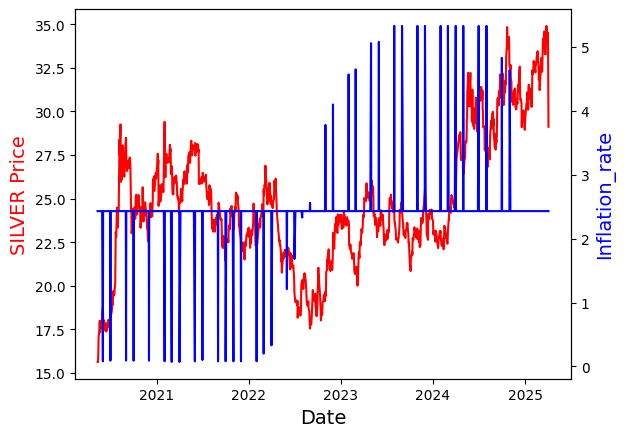

In [37]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.Inflation_rate  ,color="blue")
ax2.set_ylabel("Inflation_rate",color="blue",fontsize=14)

Text(0, 0.5, 'MA_7 ')

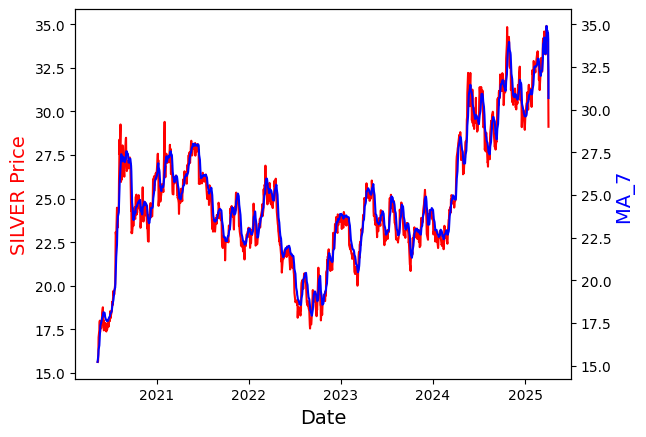

In [38]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.MA_7,color="blue")
ax2.set_ylabel("MA_7 ",color="blue",fontsize=14)

Text(0, 0.5, 'Interest_rates   ')

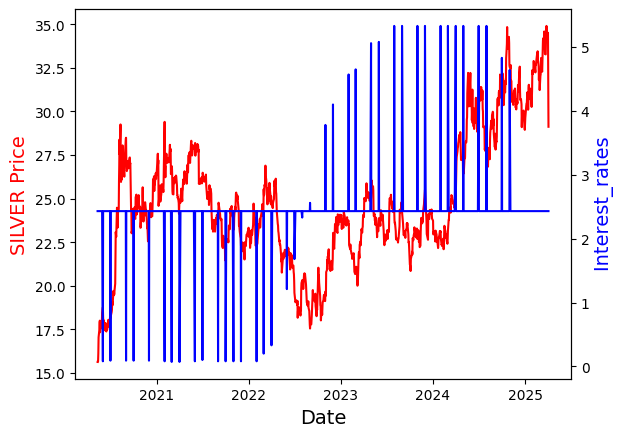

In [39]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.Interest_rates  ,color="blue")
ax2.set_ylabel("Interest_rates   ",color="blue",fontsize=14)

Text(0, 0.5, 'GDP     ')

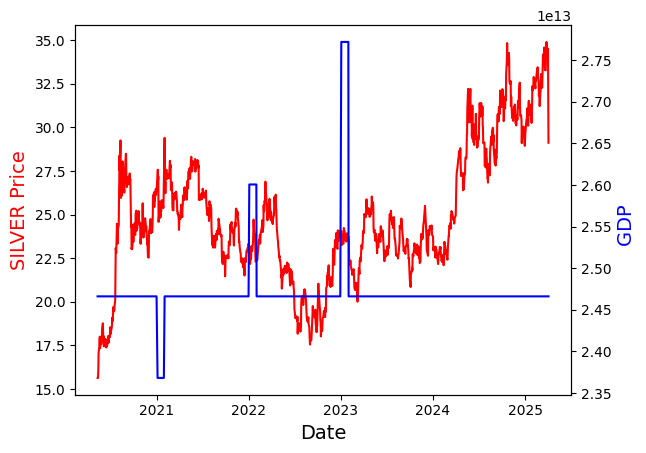

In [40]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.GDP               ,color="blue")
ax2.set_ylabel("GDP     ",color="blue",fontsize=14)

Text(0, 0.5, 'DebtToGDP')

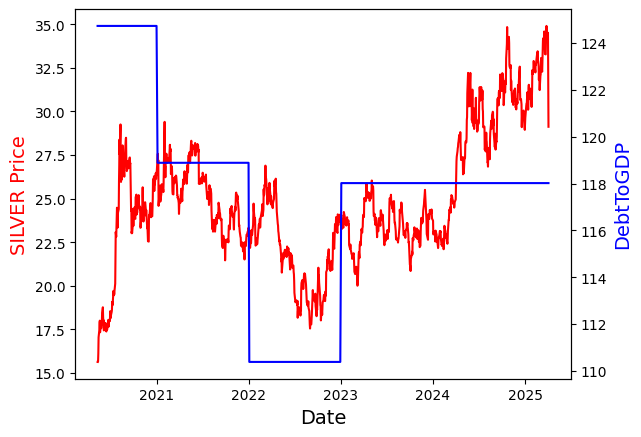

In [41]:
  
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.DebtToGDP               ,color="blue")
ax2.set_ylabel("DebtToGDP",color="blue",fontsize=14)

Text(0, 0.5, 'ETF_Value ')

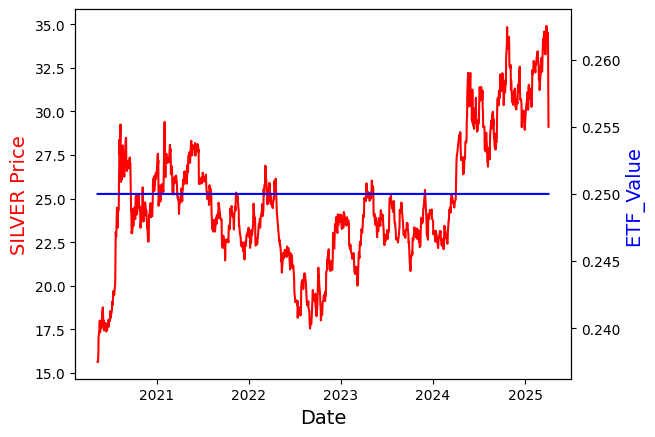

In [42]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.ETF_Value ,color="blue")
ax2.set_ylabel("ETF_Value ",color="blue",fontsize=14)

### 3.4 Seting Index of data frame is as a Date column

In [43]:
commodity_data_df = commodity_data
commodity_data_df.set_index('Date', drop=True, inplace=True)

## STEP 4 : Split and Normalize Data
### 4.1 Splitting Data into test and train data set

Train-Test Split for Time Series Data
Unlike traditional machine learning problems, time series data should not be shuffled randomly. Instead, you should split based on time:

Training Set: Data before a selected date (e.g., before 2022-01-01) or 80%
Testing Set: Data after that date (e.g., 2022-01-01 onward) or 20 %

In [44]:
import pandas as pd

# Convert index to datetime if not already
commodity_data_df.index = pd.to_datetime(commodity_data_df.index)

# Define 80-20% split based on row count
split_index = int(len(commodity_data_df) * 0.80)  
split_date = commodity_data_df.index[split_index]  

# Train-test split
train_df = commodity_data_df.loc[:split_date]  
test_df = commodity_data_df.loc[split_date:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")


Train size: (1078, 23), Test size: (270, 23)


In [45]:
# Separate features and target

# Select features and target
X_train = train_df.drop(columns=['tomorrow_price', 'Close' ])
y_train = train_df['Close']
X_test = test_df.drop(columns=['tomorrow_price', 'Close'])
y_test = test_df['Close']


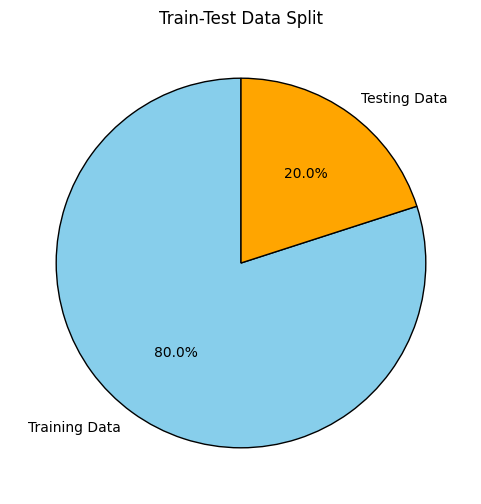

In [46]:
import matplotlib.pyplot as plt

# Compute sizes
train_size = len(train_df)
test_size = len(test_df)

# Labels and sizes
labels = ['Training Data', 'Testing Data']
sizes = [train_size, test_size]
colors = ['skyblue', 'orange']

# Create Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})

# Title
plt.title('Train-Test Data Split')
plt.show()


### 4.2 Scaling Data Properly
Econometric Models (ARIMA, GARCH, VAR):
These models work with raw data, so no need to scale.

Machine Learning Models (XGBoost, Random Forest, LSTM):
These models benefit from feature scaling to improve performance.

Scaling for ML Models
MinMax Scaling (for XGBoost, RF): Works well for tree-based models.
Standard Scaling (for LSTM): Ensures that values are normally distributed.

In [47]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)

# # Rescale y_train
# scaler_y = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_minmax.transform(y_test.values.reshape(-1, 1)).ravel()



#### This is how Feed Data into Different Models


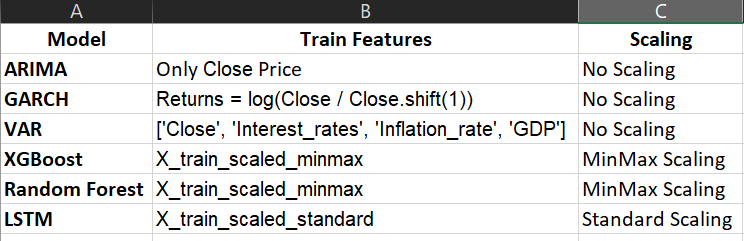

#### 4.3  Define Forcasting Function for model evaluation

In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# DataFrame to store the results
best_results_df = pd.DataFrame()

# Function to compute forecast accuracy and store the forecasted values
def forecast_accuracy(forecast, actual, Model_Object, model):
    mape = np.mean(np.abs((forecast - actual) / np.where(actual != 0, actual, np.nan))) * 100  # MAPE
    me = np.mean(forecast - actual)  # ME
    mse = np.mean((forecast - actual) ** 2)  # MSE
    mae = np.mean(np.abs(forecast - actual))  # MAE
    r2 = r2_score(actual, forecast)  # R-squared
    rmse = np.sqrt(mse)  # RMSE

    print(f"\nModel: {model}")
    print(f"ME: {me:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

    return {
        "Model": model,
        "ME": me,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R-squared": r2,
        "MAPE": mape,
        "Model_Object": Model_Object,
        "Forecasted Values": [forecast],  # Store forecasted values
        
    }


## Step 5 : MODEL BUILDING

The model-building process for forecasting commodity prices is structured into two parallel workflows: econometric models and ML & DL models,

**Econometric Models**
1. ARIMA
2. GARCH
3. VAR

   
**Machine Learning**

4. XGBOOST
5. RANDOM FOREST
6. LSTM

**Each model building below steps:**
1. Build
2. Forecast
3. evaluate
4. future forecast
5. Visulize


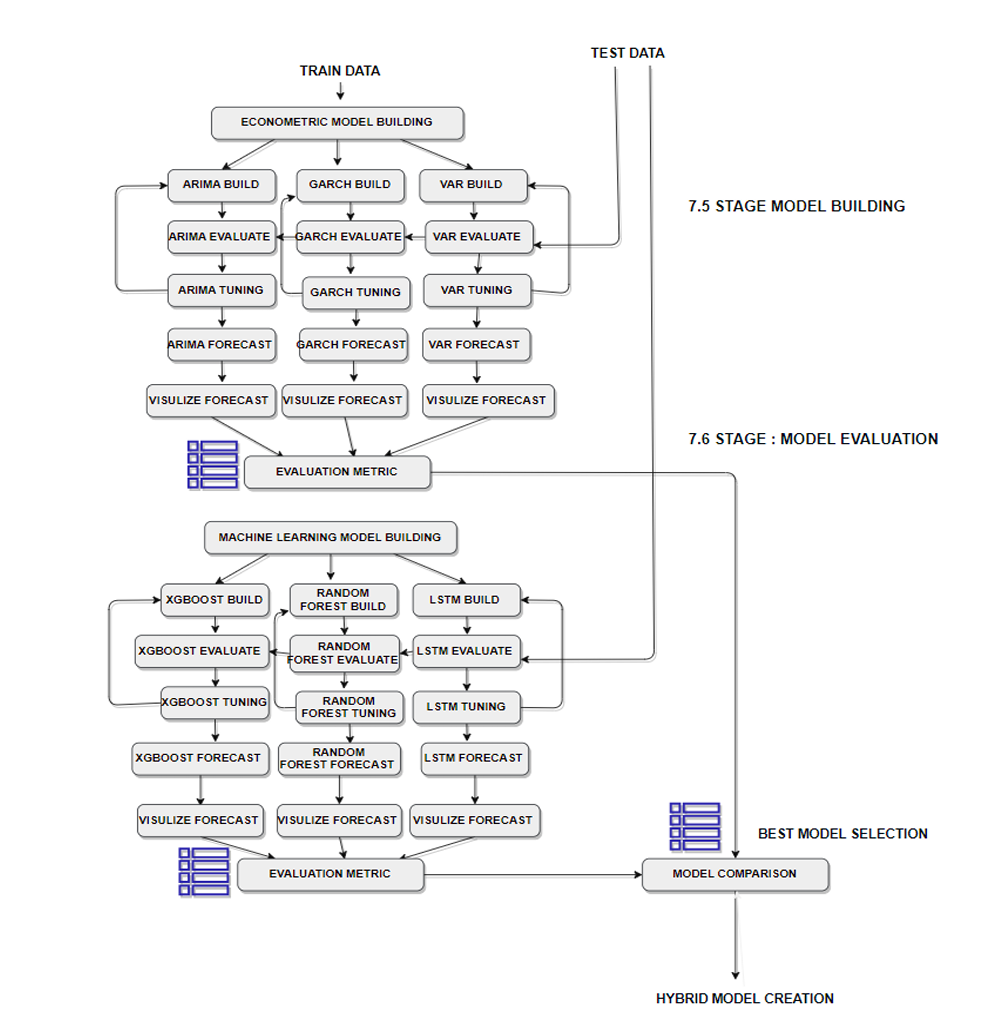

## 5.1 ARIMA Model building



#### Model 1 : RANDOM ORDER 0,1,0

In [49]:
arima_model_1 = ARIMA(y_train, order=(0,1,0))
arima_fitted_model_1 = arima_model_1.fit()  

# Forecasting the next steps
arima_forecast_results_model_1 = arima_fitted_model_1.get_forecast(steps=len(y_test))  # Get forecasted values with confidence intervals

# Extract the forecasted values
fc_model_1 = arima_forecast_results_model_1.predicted_mean

# Extract confidence intervals
conf_model_1 = arima_forecast_results_model_1.conf_int()

# Optionally, you can also get standard errors
se_model_1 = arima_forecast_results_model_1.se_mean  # Standard errors of the forecasts

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

In [50]:
# Create a DataFrame to hold the forecast results
forecast_df_model_1 = pd.DataFrame({'Forecast': fc_model_1.values}, index=y_test.index)

# Add confidence intervals to the DataFrame
forecast_df_model_1['lower_series'] = conf_model_1.iloc[:, 0].values  # Lower confidence interval
forecast_df_model_1['upper_series'] = conf_model_1.iloc[:, 1].values  # Upper confidence interval

# Print the forecast results
print(forecast_df_model_1)

            Forecast  lower_series  upper_series
Date                                            
2024-08-21    29.476     28.477515     30.474485
2024-08-22    29.476     28.063929     30.888071
2024-08-23    29.476     27.746573     31.205426
2024-08-26    29.476     27.479030     31.472970
2024-08-27    29.476     27.243320     31.708680
...              ...           ...           ...
2025-04-03    29.476     13.191203     45.760796
2025-04-03    29.476     13.160621     45.791378
2025-04-04    29.476     13.130097     45.821903
2025-04-04    29.476     13.099629     45.852370
2025-04-04    29.476     13.069218     45.882782

[270 rows x 3 columns]


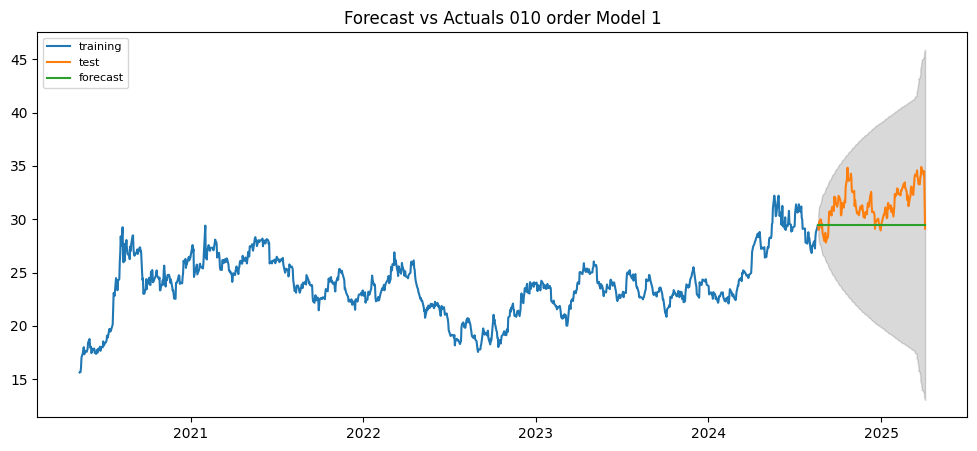

In [51]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='test')
plt.plot(forecast_df_model_1.Forecast, label='forecast')
plt.fill_between(forecast_df_model_1.index, forecast_df_model_1.lower_series, forecast_df_model_1.upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals 010 order Model 1')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [52]:
# Store ARIMA model results in DataFrame
results_df_arima = pd.DataFrame()
arima_metrics = forecast_accuracy(fc_model_1.values, y_test.values, arima_fitted_model_1,'ARIMA-010_model_1')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arima_metrics])], ignore_index=True)
results_df_arima


Model: ARIMA-010_model_1
ME: -3.0436, MSE: 12.4813, MAE: 3.1359, RMSE: 3.5329, R²: -2.8789, MAPE: 9.40%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,-3.043608,12.481294,3.135889,3.532887,-2.878893,9.397197,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.47599983215332, 29.47599983215332, 29.475..."


### ARIMA MODEL : 2 - ORDER 1,2,2

In [53]:
# model_best = ARIMA(y_train, order=model_auto.order)  
arima_model_model_2 = ARIMA(y_train, order=(1,2,2))
arima_fitted_model_2 = arima_model_model_2.fit()  

# Forecasting the next steps
arima_forecast_results_model_2 = arima_fitted_model_2.get_forecast(steps=len(y_test))  # Get forecasted values with confidence intervals

# Extract the forecasted values
fc_model_2 = arima_forecast_results_model_2.predicted_mean

# Extract confidence intervals
conf_model_2 = arima_forecast_results_model_2.conf_int()

# Optionally, you can also get standard errors
se_model_2 = arima_forecast_results_model_2.se_mean  # Standard errors of the forecasts

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
# Create a DataFrame to hold the forecast results
forecast_df_model_2 = pd.DataFrame({'Forecast': fc_model_2.values}, index=y_test.index)

# Add confidence intervals to the DataFrame
forecast_df_model_2['lower_series'] = conf_model_2.iloc[:, 0].values  # Lower confidence interval
forecast_df_model_2['upper_series'] = conf_model_2.iloc[:, 1].values  # Upper confidence interval

# Print the forecast results
print(forecast_df_model_2)

             Forecast  lower_series  upper_series
Date                                             
2024-08-21  29.490233     28.496549     30.483918
2024-08-22  29.502724     28.165343     30.840105
2024-08-23  29.515670     27.891292     31.140049
2024-08-26  29.528498     27.663647     31.393348
2024-08-27  29.541356     27.462520     31.620192
...               ...           ...           ...
2025-04-03  32.895723     16.229027     49.562419
2025-04-03  32.908575     16.204347     49.612803
2025-04-04  32.921427     16.179705     49.663149
2025-04-04  32.934279     16.155100     49.713458
2025-04-04  32.947131     16.130532     49.763730

[270 rows x 3 columns]


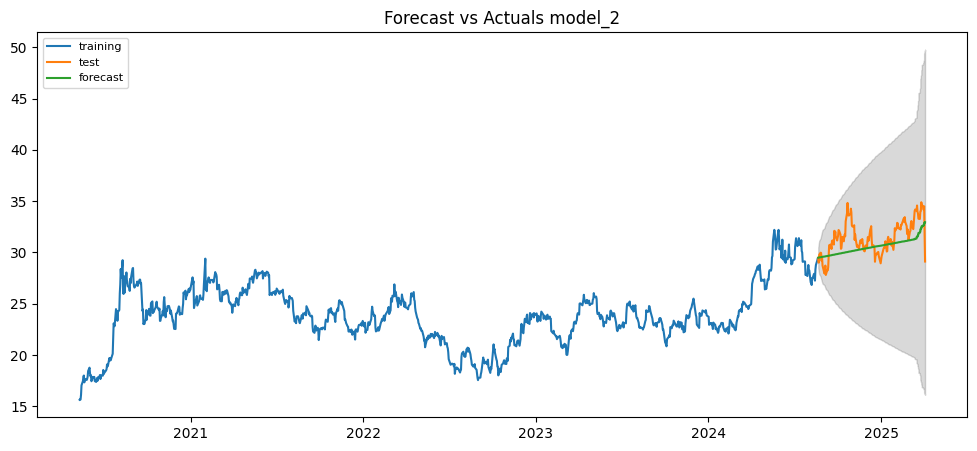

In [55]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='test')
plt.plot(forecast_df_model_2.Forecast, label='forecast')
plt.fill_between(forecast_df_model_2.index, forecast_df_model_2.lower_series, forecast_df_model_2.upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals model_2')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [56]:
arimametrics = forecast_accuracy(fc_model_2.values, y_test.values, arima_fitted_model_2,'ARIMA-122_model_2')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arimametrics])], ignore_index=True)
results_df_arima


Model: ARIMA-122_model_2
ME: -1.3011, MSE: 3.3495, MAE: 1.6067, RMSE: 1.8302, R²: -0.0409, MAPE: 4.86%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,-3.043608,12.481294,3.135889,3.532887,-2.878893,9.397197,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.47599983215332, 29.47599983215332, 29.475..."
1,ARIMA-122_model_2,-1.301068,3.349459,1.606656,1.830153,-0.040933,4.863492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.49023341618893, 29.502723826745562, 29.51..."


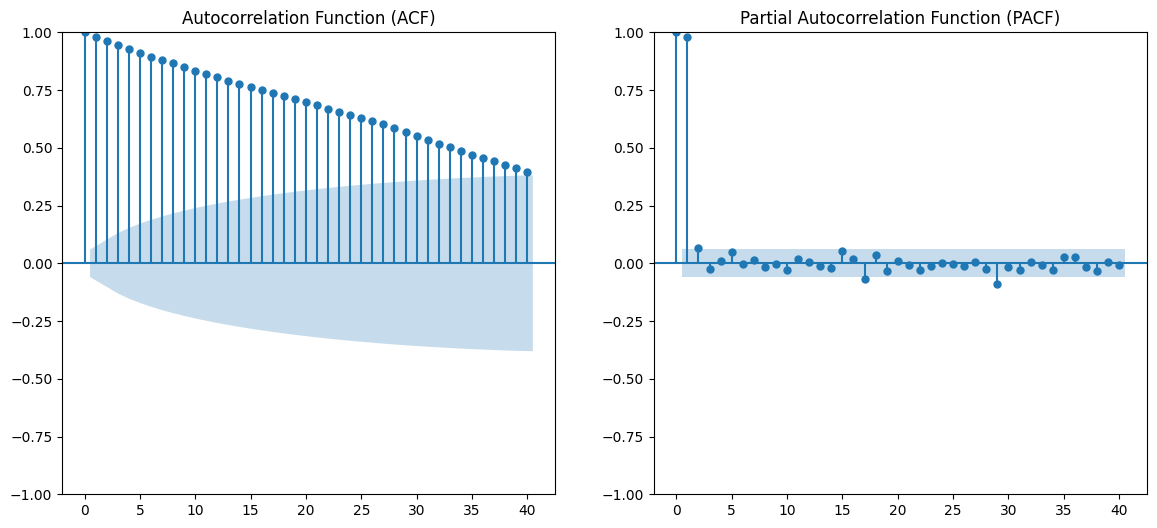

In [57]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF plot
sm.graphics.tsa.plot_acf(y_train, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

### Run with Auto ARIMA best order 

### MODEL : 3 - AUTO ARIMA 

In [58]:
from pmdarima import auto_arima

# Auto ARIMA to find best (p, d, q)
model_auto = auto_arima(y_train, seasonal=False, stepwise=True, trace=True,max_p=10, max_q=10, d=1,  
                        information_criterion='bic')

# Best order
print("Best ARIMA order:", model_auto.order)


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=1629.186, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1616.924, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1612.561, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1613.076, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1610.628, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1619.172, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.899 seconds
Best ARIMA order: (0, 1, 0)


In [59]:
model_auto.order

(0, 1, 0)

In [60]:
from statsmodels.tsa.arima.model import ARIMA

# Use the best order from auto_arima
best_p, best_d, best_q = model_auto.order
arima_model_best = ARIMA(y_train, order=(best_p, best_d, best_q))
arima_fitted = arima_model_best.fit()

# Forecast
arima_forecast_results = arima_fitted.get_forecast(steps=len(y_test))

# Extract the forecasted values and confidence intervals
fc = arima_forecast_results.predicted_mean
conf = arima_forecast_results.conf_int()


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

In [61]:
arimametrics = forecast_accuracy(fc.values, y_test.values, arima_fitted,'ARIMA_AUTO_model-3')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arimametrics])], ignore_index=True)
results_df_arima


Model: ARIMA_AUTO_model-3
ME: -3.0436, MSE: 12.4813, MAE: 3.1359, RMSE: 3.5329, R²: -2.8789, MAPE: 9.40%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,-3.043608,12.481294,3.135889,3.532887,-2.878893,9.397197,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.47599983215332, 29.47599983215332, 29.475..."
1,ARIMA-122_model_2,-1.301068,3.349459,1.606656,1.830153,-0.040933,4.863492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.49023341618893, 29.502723826745562, 29.51..."
2,ARIMA_AUTO_model-3,-3.043608,12.481294,3.135889,3.532887,-2.878893,9.397197,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.47599983215332, 29.47599983215332, 29.475..."


### Model : 4 -ARIMA WITHOUT MICORECONOMIC FACTORS

In [62]:
# model_best = ARIMA(y_train, order=model_auto.order)  
arima_model_micro = ARIMA(y_train, order=(1,3,2)) #123 #132
arima_fitted_micro = arima_model_micro.fit()  

# Forecasting the next steps
arima_forecast_results_micro = arima_fitted_micro.get_forecast(steps=len(y_test))  # Get forecasted values with confidence intervals

# Extract the forecasted values
fc_micro = arima_forecast_results_micro.predicted_mean

# Extract confidence intervals
conf_micro = arima_forecast_results_micro.conf_int()

# Optionally, you can also get standard errors
se_micro = arima_forecast_results_micro.se_mean  # Standard errors of the forecasts

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

In [63]:
# Create a DataFrame to hold the forecast results
forecast_df_micro = pd.DataFrame({'Forecast': fc_micro.values}, index=y_test.index)

# Add confidence intervals to the DataFrame
forecast_df_micro['lower_series'] = conf_micro.iloc[:, 0].values  # Lower confidence interval
forecast_df_micro['upper_series'] = conf_micro.iloc[:, 1].values  # Upper confidence interval

# Print the forecast results
print(forecast_df_micro)

             Forecast  lower_series  upper_series
Date                                             
2024-08-21  29.500291     28.504496     30.496087
2024-08-22  29.524467     28.182444     30.866491
2024-08-23  29.548867     27.926039     31.171695
2024-08-26  29.573457     27.710715     31.436199
2024-08-27  29.598240     27.521728     31.674752
...               ...           ...           ...
2025-04-03  42.667950     -0.675781     86.011681
2025-04-03  42.743318     -0.882921     86.369557
2025-04-04  42.818879     -1.091178     86.728935
2025-04-04  42.894633     -1.300552     87.089818
2025-04-04  42.970580     -1.511047     87.452208

[270 rows x 3 columns]


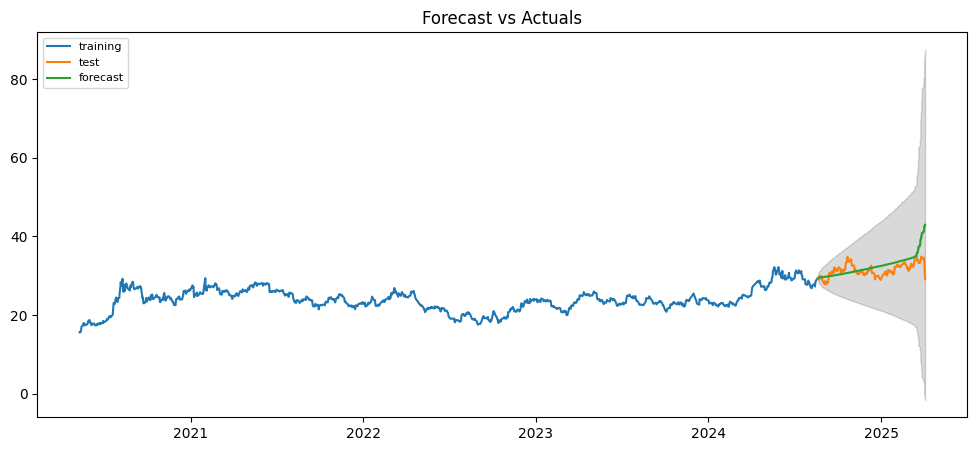

In [64]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='test')
plt.plot(forecast_df_micro.Forecast, label='forecast')
plt.fill_between(forecast_df_micro.index, forecast_df_micro.lower_series, forecast_df_micro.upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
arimametrics = forecast_accuracy(fc_micro.values, y_test.values,arima_fitted_micro, 'ARIMA-WITHOUT-MICRO_model-4')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arimametrics])], ignore_index=True)
results_df_arima


Model: ARIMA-WITHOUT-MICRO_model-4
ME: 2.5559, MSE: 15.5791, MAE: 3.0245, RMSE: 3.9470, R²: -3.8416, MAPE: 9.17%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,-3.043608,12.481294,3.135889,3.532887,-2.878893,9.397197,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.47599983215332, 29.47599983215332, 29.475..."
1,ARIMA-122_model_2,-1.301068,3.349459,1.606656,1.830153,-0.040933,4.863492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.49023341618893, 29.502723826745562, 29.51..."
2,ARIMA_AUTO_model-3,-3.043608,12.481294,3.135889,3.532887,-2.878893,9.397197,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.47599983215332, 29.47599983215332, 29.475..."
3,ARIMA-WITHOUT-MICRO_model-4,2.555905,15.579109,3.024527,3.947038,-3.841621,9.171319,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.50029138234624, 29.52446732521019, 29.548..."


In [66]:
# Predict future steps beyond y_test
future_steps = 5  # Number of days to predict ahead (adjust as needed)
future_forecast_micro = arima_fitted_micro.get_forecast(steps=future_steps)

# Extract forecasted values
future_fc_micro = future_forecast_micro.predicted_mean

# Extract confidence intervals
future_conf_micro = future_forecast_micro.conf_int()

# Create a new DataFrame to store future forecast results
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')  # 'B' ensures business days
future_forecast_df = pd.DataFrame({'Forecast': future_fc_micro.values}, index=future_dates)
future_forecast_df['lower_series'] = future_conf_micro.iloc[:, 0].values
future_forecast_df['upper_series'] = future_conf_micro.iloc[:, 1].values

# Print the future forecast
print("Future Predictions:")
print(future_forecast_df)


Future Predictions:
             Forecast  lower_series  upper_series
2025-04-07  29.500291     28.504496     30.496087
2025-04-08  29.524467     28.182444     30.866491
2025-04-09  29.548867     27.926039     31.171695
2025-04-10  29.573457     27.710715     31.436199
2025-04-11  29.598240     27.521728     31.674752


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Model : 5 - ARIMA WITH MICROECONOMIC FACTORS

In [67]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Select microeconomic factors from the scaled data
exog_train = X_train_scaled_minmax[:, [X_train.columns.get_loc(col) for col in ['Interest_rates', 'Inflation_rate', 'GDP', 'DebtToGDP', 'ETF_Value','Sentiment_score']]]
exog_test = X_test_scaled_minmax[:, [X_test.columns.get_loc(col) for col in ['Interest_rates', 'Inflation_rate', 'GDP', 'DebtToGDP', 'ETF_Value','Sentiment_score']]]

# Train SARIMAX Model
arimax_model_micro_w = SARIMAX(y_train, exog=exog_train, order=(1,3,2))
arimax_fitted_micro_w = arimax_model_micro_w.fit()

# Forecast using the trained model
arimax_forecast_micro_w = arimax_fitted_micro_w.get_forecast(steps=len(y_test), exog=exog_test)

# Get forecasted values
fc_micro_w = arimax_forecast_micro_w.predicted_mean

# Extract confidence intervals
conf_micro_w = arimax_forecast_micro_w.conf_int()

# Get standard errors
se_micro_w = arimax_forecast_micro_w.se_mean  # Standard errors of the forecasts

# Create a DataFrame to store forecast results
forecast_df_micro_w = pd.DataFrame({'Forecast': fc_micro_w.values}, index=y_test.index)
forecast_df_micro_w['lower_series'] = conf_micro_w.iloc[:, 0].values  # Lower confidence interval
forecast_df_micro_w['upper_series'] = conf_micro_w.iloc[:, 1].values  # Upper confidence interval

# Print the forecast results
print(forecast_df_micro_w)


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


             Forecast  lower_series  upper_series
Date                                             
2024-08-21  29.503075     28.511900     30.494249
2024-08-22  29.529512     28.192088     30.866937
2024-08-23  29.555962     27.938569     31.173355
2024-08-26  29.582361     27.726014     31.438708
2024-08-27  29.608714     27.539705     31.677724
...               ...           ...           ...
2025-04-03  34.934183      0.804961     69.063406
2025-04-03  34.948638      0.620452     69.276823
2025-04-04  34.963047      0.435030     69.491063
2025-04-04  34.977410      0.248692     69.706129
2025-04-04  34.991729      0.061436     69.922021

[270 rows x 3 columns]


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [68]:
arimametrics = forecast_accuracy(fc_micro_w.values, y_test.values,arimax_fitted_micro_w, 'ARIMA_MAX-WITH-MICROECO-SENTI_model-5')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arimametrics])], ignore_index=True)
results_df_arima


Model: ARIMA_MAX-WITH-MICROECO-SENTI_model-5
ME: -0.0003, MSE: 1.6200, MAE: 0.8619, RMSE: 1.2728, R²: 0.4965, MAPE: 2.71%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,-3.043608,12.481294,3.135889,3.532887,-2.878893,9.397197,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.47599983215332, 29.47599983215332, 29.475..."
1,ARIMA-122_model_2,-1.301068,3.349459,1.606656,1.830153,-0.040933,4.863492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.49023341618893, 29.502723826745562, 29.51..."
2,ARIMA_AUTO_model-3,-3.043608,12.481294,3.135889,3.532887,-2.878893,9.397197,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.47599983215332, 29.47599983215332, 29.475..."
3,ARIMA-WITHOUT-MICRO_model-4,2.555905,15.579109,3.024527,3.947038,-3.841621,9.171319,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[29.50029138234624, 29.52446732521019, 29.548..."
4,ARIMA_MAX-WITH-MICROECO-SENTI_model-5,-0.000300,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."


In [69]:
arime_best = results_df_arima.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
arime_best["Model"]="ARIMA"
best_results_df = pd.concat([best_results_df, arime_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,-0.0003,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."




###  **1. ARIMA_MAX-WITH-MICROECO-SENTI_model-5** (Best Performer)
- **RMSE**: **1.27** (lowest)
- **MAE**: 0.86 (lowest)
- **R²**: **0.50** (only positive R², indicating a decent fit)
- **MAPE**: **2.71%** (lowest)
- **Conclusion**: This model, which includes **macroeconomic + sentiment data**, clearly outperforms others across all metrics.

---

###  **2. ARIMA-122_model_2**
- **RMSE**: 1.83
- **MAE**: 1.61
- **R²**: -0.04 (close to 0, much better than other negatives)
- **MAPE**: 4.86%
- **Conclusion**: A well-tuned standard ARIMA(p=1,d=2,q=2) model — not as good as model-5, but still acceptable.

---

###  **3. ARIMA-WITHOUT-MICRO_model-4**
- **RMSE**: 3.95
- **MAE**: 3.02
- **R²**: -3.84 (very poor fit)
- **MAPE**: 9.17%
- **Conclusion**: Without macroeconomic input, model performance declines significantly.

---

###  **4. ARIMA-010_model_1** & **ARIMA_AUTO_model-3** (Identical Results)
- **RMSE**: 3.53
- **MAE**: 3.14
- **R²**: -2.88
- **MAPE**: 9.40%
- **Conclusion**: These baseline models are the **least accurate**, and overfit or underfit the trend badly.

---

###  Key Takeaways:
| Model                                   | RMSE   | MAE   | R²      | MAPE    | Comment                                     |
|----------------------------------------|--------|-------|---------|---------|---------------------------------------------|
| **ARIMA_MAX-WITH-MICROECO-SENTI_model-5** | **1.27** | **0.86** | **0.50**  | **2.71%** | 🔥 Best performer – use this in ensemble     |
| ARIMA-122_model_2                      | 1.83   | 1.61  | -0.04   | 4.86%   | Decent performance                          |
| ARIMA-WITHOUT-MICRO_model-4           | 3.95   | 3.02  | -3.84   | 9.17%   | Weak – needs more contextual data           |
| ARIMA-010_model_1 / ARIMA_AUTO_model-3 | 3.53   | 3.14  | -2.88   | 9.40%   | Worst – avoid without tuning or inputs      |

---


## 5.2 GARCH Model building

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller


In [71]:
adf_test = adfuller(train_df['Log_Returns'])
print(f'ADF Test Statistic: {adf_test[0]}')
print(f'P-value: {adf_test[1]}')

# If p-value < 0.05, data is stationary, and we can proceed with GARCH.
garch_results_df = pd.DataFrame()

ADF Test Statistic: -35.274825535272136
P-value: 0.0


In [72]:
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def plot_residuals(residuals):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(211)
    plt.plot(residuals, label="Standardized Residuals")
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Standardized Residuals')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()

    plt.subplot(212)
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histogram of Standardized Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def plot_forecasts(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted', color='orange')
    plt.title('GARCH Model Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Gold Prices')
    plt.legend()
    plt.grid()
    plt.show()

In [73]:

# Convert prices to log returns
y_train_log_returns = np.log(y_train / y_train.shift(1)).dropna()
y_test_log_returns = np.log(y_test / y_test.shift(1)).dropna()

### MODEL: 1 GARCH   p,q order (1,2)


Model: GARCH-12_model-1
ME: -8.8426, MSE: 81.4089, MAE: 8.8426, RMSE: 9.0227, R²: -24.3000, MAPE: 26.96%


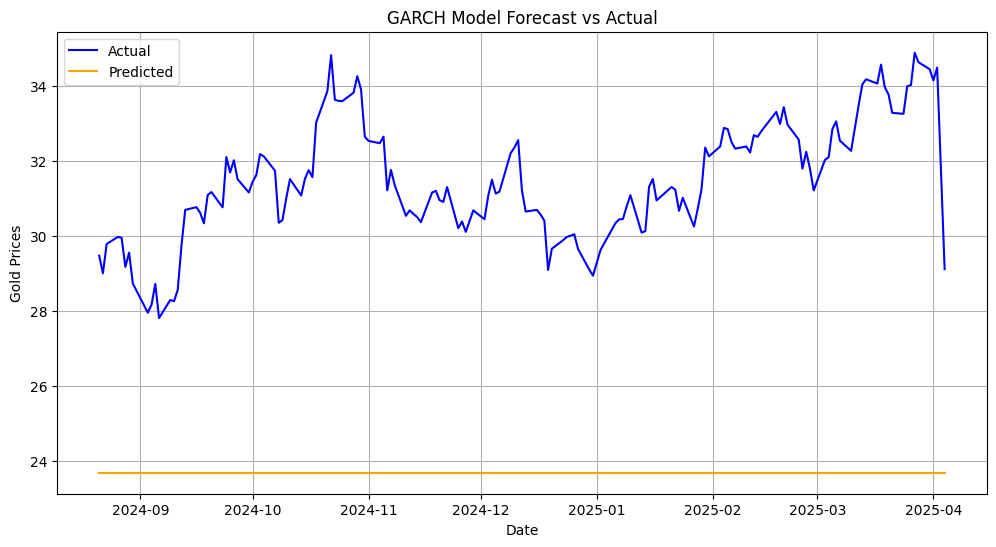

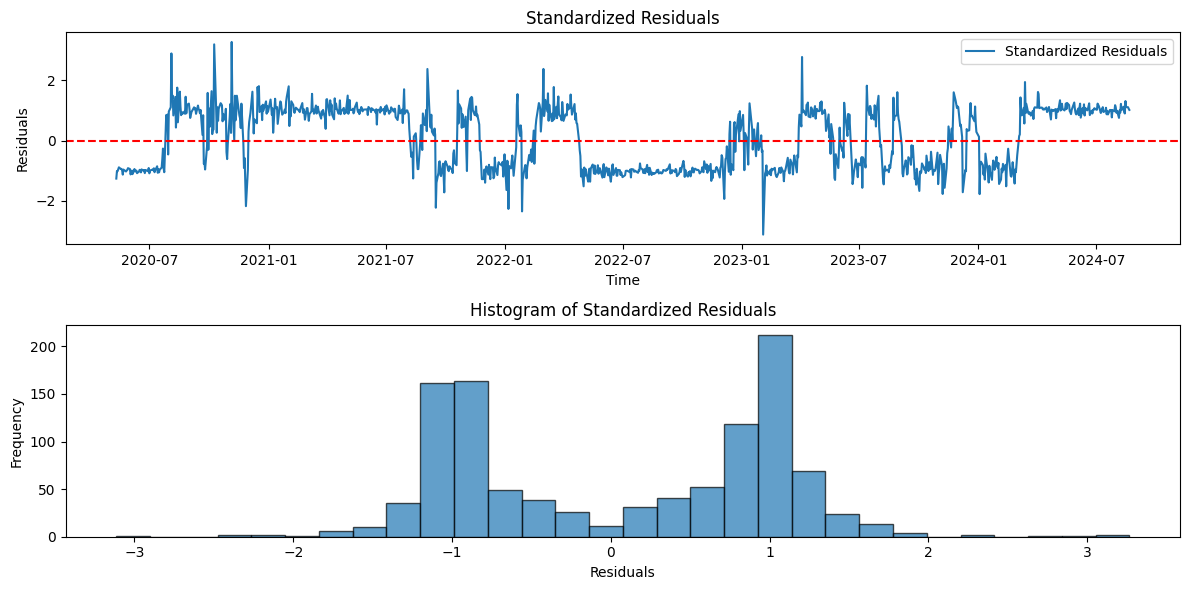

In [74]:
# Define GARCH model parameters
p, q = 1, 2  # Try different values for tuning
garch = arch_model(y_train , vol='GARCH', p=p, q=q, dist='t')
fgarch = garch.fit(disp='off')

# Forecasting
garch_forecast = fgarch.forecast(horizon=len(y_test))
garch_forecast_series = garch_forecast.mean.iloc[-len(y_test):].values.flatten()

# Reverse scaling
#garch_predicted_prices = scaler_minmax.inverse_transform(garch_forecast_series.reshape(-1, 1)).flatten()
garch_predicted_prices = garch_forecast_series

# Residuals analysis
resid = fgarch.resid
st_resid = resid / fgarch.conditional_volatility

# Error metrics
mse = mean_squared_error(y_test, garch_predicted_prices)
mae = mean_absolute_error(y_test, garch_predicted_prices)
mape = mean_absolute_percentage_error(y_test, garch_predicted_prices)

# # Forecasting
#forecast_accuracy(garch_forecast_series.flatten(), y_test_eco, "GARCH")
garchmametrics = forecast_accuracy(garch_forecast_series, y_test, fgarch, "GARCH-12_model-1")
garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garchmametrics])], ignore_index=True)

# Plot results
plot_forecasts(y_test, garch_predicted_prices)
plot_residuals(st_resid)



### MODEL: 2 GARCH   p,q order (1,1)

In [75]:
# # Define GARCH model parameters
# p, q = 1, 1  # Try different values (1,1), (1,2), (2,2), (2,3)
# garch = arch_model(y_train_log_returns, vol="GARCH", p=p, q=q, dist="t")
# fgarch = garch.fit(disp="off")

# # Forecasting
# garch_forecast = fgarch.forecast(horizon=len(y_test_log_returns))
# garch_forecast_series = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()

# # Convert forecasted log returns back to price predictions
# y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
# garch_predicted_prices = y_test_prices[0] * np.exp(np.cumsum(garch_forecast_series))

# # Evaluate model
# garch_metrics = forecast_accuracy(garch_predicted_prices, y_test.iloc[-len(garch_forecast_series):].values,fgarch, "GARCH-11_model-2")
# garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garch_metrics])], ignore_index=True)

# # Plot results
# plot_forecasts(y_test.iloc[-len(garch_forecast_series):], garch_predicted_prices)




Model: GARCH-11_model-2
ME: -2.2952, MSE: 7.1607, MAE: 2.4155, RMSE: 2.6759, R²: -1.2411, MAPE: 7.27%


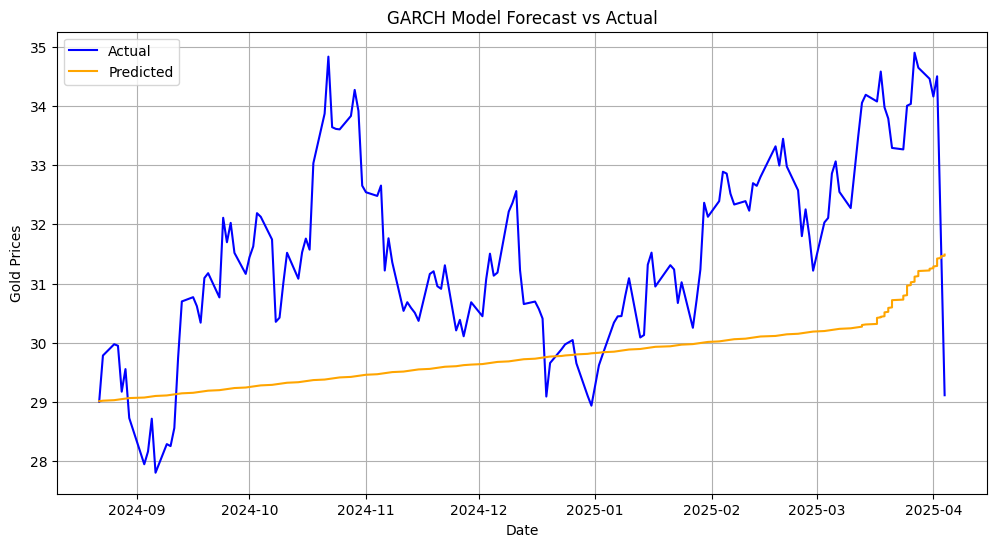

In [76]:
# Define GARCH model parameters
p, q = 1, 1  # Try different values (1,1), (1,2), (2,2), (2,3)

# Rescale log returns to avoid convergence and overflow issues
scale_factor = 100
y_train_scaled_g = y_train_log_returns * scale_factor

# Fit the GARCH model
garch = arch_model(y_train_scaled_g, vol="GARCH", p=p, q=q, dist="t")
fgarch = garch.fit(disp="off")

# Forecasting
garch_forecast = fgarch.forecast(horizon=len(y_test_log_returns))
garch_forecast_scaled = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()

# Rescale the forecasted returns back to original scale
garch_forecast_series = garch_forecast_scaled / scale_factor

# Convert forecasted log returns back to price predictions
y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
cumsum_forecast = np.cumsum(garch_forecast_series)
cumsum_forecast = np.clip(cumsum_forecast, a_min=-100, a_max=100)  # Clip to avoid overflow

garch_predicted_prices = y_test_prices[0] * np.exp(cumsum_forecast)

# Check for valid predictions before evaluation
if np.isfinite(garch_predicted_prices).all():
    garch_metrics = forecast_accuracy(
        garch_predicted_prices,
        y_test.iloc[-len(garch_forecast_series):].values,
        fgarch,
        "GARCH-11_model-2"
    )
    garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garch_metrics])], ignore_index=True)

    # Plot results
    plot_forecasts(y_test.iloc[-len(garch_forecast_series):], garch_predicted_prices)
else:
    print("⚠️ Forecasted prices contain inf or NaN. Evaluation skipped.")


### MODEL: 3 GARCH   p,q order (2,2)


Model: GARCH-22_model-2
ME: -2.3084, MSE: 7.2299, MAE: 2.4276, RMSE: 2.6889, R²: -1.2628, MAPE: 7.31%


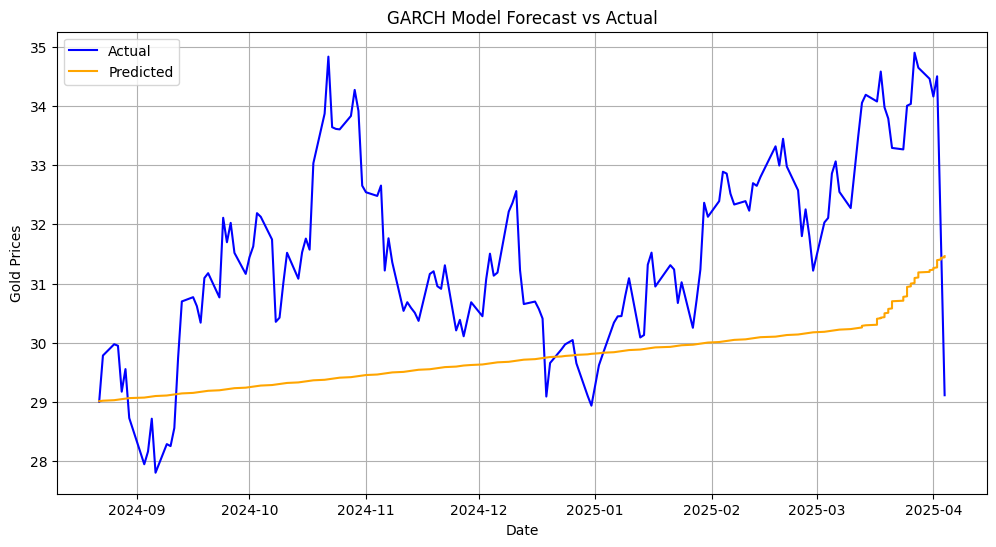

In [77]:
# Define GARCH model parameters
p, q = 2,2  # Try different values (1,1), (1,2), (2,2), (2,3)

# Rescale log returns to avoid convergence and overflow issues
scale_factor = 100
y_train_scaled_g = y_train_log_returns * scale_factor

# Fit the GARCH model
garch = arch_model(y_train_scaled_g, vol="GARCH", p=p, q=q, dist="t")
fgarch = garch.fit(disp="off")

# Forecasting
garch_forecast = fgarch.forecast(horizon=len(y_test_log_returns))
garch_forecast_scaled = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()

# Rescale the forecasted returns back to original scale
garch_forecast_series = garch_forecast_scaled / scale_factor

# Convert forecasted log returns back to price predictions
y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
cumsum_forecast = np.cumsum(garch_forecast_series)
cumsum_forecast = np.clip(cumsum_forecast, a_min=-100, a_max=100)  # Clip to avoid overflow

garch_predicted_prices = y_test_prices[0] * np.exp(cumsum_forecast)

# Check for valid predictions before evaluation
if np.isfinite(garch_predicted_prices).all():
    garch_metrics = forecast_accuracy(
        garch_predicted_prices,
        y_test.iloc[-len(garch_forecast_series):].values,
        fgarch,
        "GARCH-22_model-2"
    )
    garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garch_metrics])], ignore_index=True)

    # Plot results
    plot_forecasts(y_test.iloc[-len(garch_forecast_series):], garch_predicted_prices)
else:
    print("⚠️ Forecasted prices contain inf or NaN. Evaluation skipped.")


### MODEL: 4 GARCH   p,q order (2,3)


Model: GARCH-23_model-3
ME: -2.5744, MSE: 8.7274, MAE: 2.6732, RMSE: 2.9542, R²: -1.7315, MAPE: 8.04%


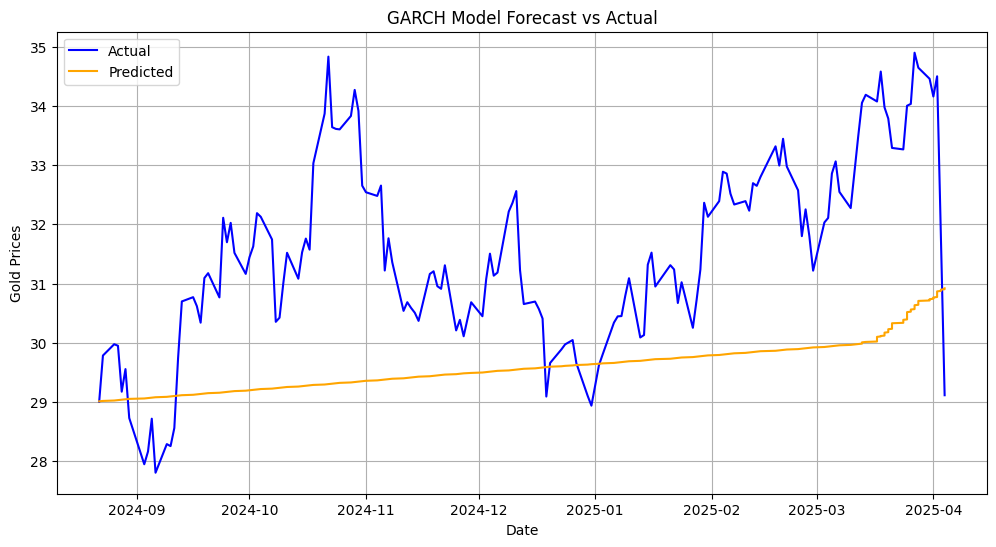

In [78]:
# Define GARCH model parameters
p, q = 2,3  # Try different values (1,1), (1,2), (2,2), (2,3)

# Rescale log returns to avoid convergence and overflow issues
scale_factor = 100
y_train_scaled_g = y_train_log_returns * scale_factor

# Fit the GARCH model
garch = arch_model(y_train_scaled_g, vol="GARCH", p=p, q=q, dist="t")
fgarch = garch.fit(disp="off")

# Forecasting
garch_forecast = fgarch.forecast(horizon=len(y_test_log_returns))
garch_forecast_scaled = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()

# Rescale the forecasted returns back to original scale
garch_forecast_series = garch_forecast_scaled / scale_factor

# Convert forecasted log returns back to price predictions
y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
cumsum_forecast = np.cumsum(garch_forecast_series)
cumsum_forecast = np.clip(cumsum_forecast, a_min=-100, a_max=100)  # Clip to avoid overflow

garch_predicted_prices = y_test_prices[0] * np.exp(cumsum_forecast)

# Check for valid predictions before evaluation
if np.isfinite(garch_predicted_prices).all():
    garch_metrics = forecast_accuracy(
        garch_predicted_prices,
        y_test.iloc[-len(garch_forecast_series):].values,
        fgarch,
        "GARCH-23_model-3"
    )
    garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garch_metrics])], ignore_index=True)

    # Plot results
    plot_forecasts(y_test.iloc[-len(garch_forecast_series):], garch_predicted_prices)
else:
    print("⚠️ Forecasted prices contain inf or NaN. Evaluation skipped.")


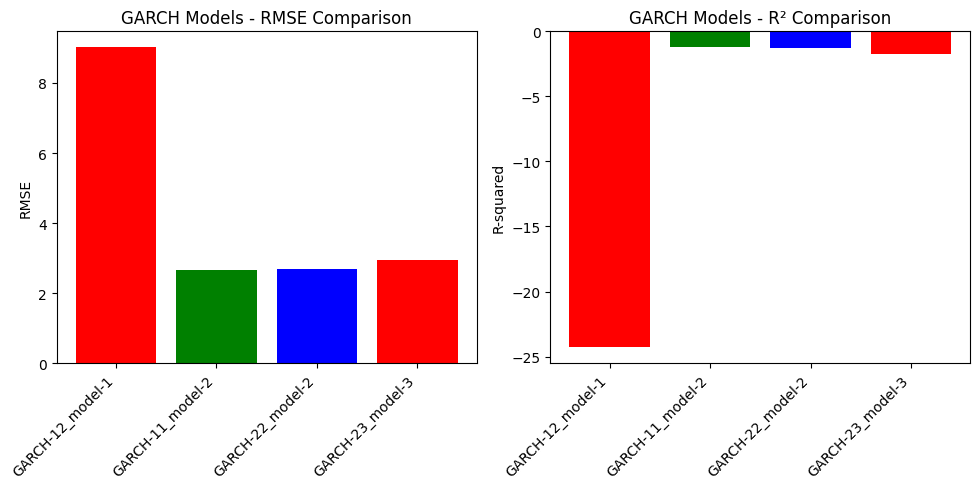

In [79]:
import matplotlib.pyplot as plt

# Extracting GARCH models from results_df
garch_models = garch_results_df[garch_results_df["Model"].str.contains("GARCH")]

# Plot performance metrics
plt.figure(figsize=(10, 5))

# RMSE Comparison
plt.subplot(1, 2, 1)
plt.bar(garch_models["Model"], garch_models["RMSE"], color=['red', 'green', 'blue'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("GARCH Models - RMSE Comparison")

# R-squared Comparison
plt.subplot(1, 2, 2)
plt.bar(garch_models["Model"], garch_models["R-squared"], color=['red', 'green', 'blue'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("R-squared")
plt.title("GARCH Models - R² Comparison")

plt.tight_layout()
plt.show()


In [80]:
garch_results_df_best = garch_results_df.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
garch_results_df_best["Model"]="GARCH"
best_results_df = pd.concat([best_results_df, garch_results_df_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,-0.000300,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."
1,GARCH,-2.295238,7.160704,2.415477,2.675949,-1.241121,7.269705,Constant Mean - GARCH ...,"[[29.014862401163633, 29.023726991001293, 29.0..."


In [127]:
garch_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,GARCH-12_model-1,-8.842574,81.408855,8.842574,9.022686,-24.299959,26.961221,Constant Mean - GARCH ...,"[[23.677033785031927, 23.677033785031927, 23.6..."
1,GARCH-11_model-2,-2.295238,7.160704,2.415477,2.675949,-1.241121,7.269705,Constant Mean - GARCH ...,"[[29.014862401163633, 29.023726991001293, 29.0..."
2,GARCH-22_model-2,-2.308411,7.229916,2.427552,2.688850,-1.262783,7.305614,Constant Mean - GARCH ...,"[[29.014769997094813, 29.023542126695638, 29.0..."
3,GARCH-23_model-3,-2.574438,8.727422,2.673216,2.954221,-1.731465,8.036940,Constant Mean - GARCH ...,"[[29.01289249419864, 29.019786107167377, 29.02..."




###  **1. GARCH-11_model-2** (Best Performer)
- **RMSE**: **2.68** (lowest)
- **MAE**: **2.42**
- **R²**: **-1.24** (least negative)
- **MAPE**: **7.27%** (lowest among all GARCH models)
- **Conclusion**: The classic **GARCH(1,1)** configuration performs the best, showing balance between bias and variance.

---

###  **2. GARCH-22_model-2**
- **RMSE**: 2.69 (very close to GARCH-11)
- **MAE**: 2.43
- **R²**: -1.26
- **MAPE**: 7.31%
- **Conclusion**: Very similar to GARCH(1,1), slightly worse in error and fit.

---

###  **3. GARCH-23_model-3**
- **RMSE**: 2.95
- **MAE**: 2.67
- **R²**: -1.73
- **MAPE**: 8.04%
- **Conclusion**: Increasing lag beyond (2,2) does not improve performance — may add noise or overfitting.

---

###  **4. GARCH-12_model-1** (Worst Performer)
- **RMSE**: **9.02** (highest)
- **MAE**: 8.84 (highest)
- **R²**: **-24.30** (very poor fit)
- **MAPE**: **26.96%**
- **Conclusion**: Performs significantly worse than others — possibly failed to capture volatility or misfitted.

---

###  Key Takeaways:

| Model              | RMSE   | MAE   | R²        | MAPE    | Comment                             |
|-------------------|--------|-------|-----------|---------|-------------------------------------|
| **GARCH-11_model-2** | **2.68** | **2.42** | **-1.24**  | **7.27%** | 🔥 Best performer – reliable choice |
| GARCH-22_model-2  | 2.69   | 2.43  | -1.26     | 7.31%   | Very similar to GARCH(1,1)          |
| GARCH-23_model-3  | 2.95   | 2.67  | -1.73     | 8.04%   | More lag → slight degradation       |
| GARCH-12_model-1  | 9.02   | 8.84  | -24.30    | 26.96%  | 🚫 Avoid – large errors, poor fit   |



## 5.3 VAR MODEL
In a VAR model, we don't separate independent (X_train) and dependent (y_train) variables like in traditional regression models. VAR treats all variables as potentially influencing each other, meaning:

The model doesn't require manually selecting X_train and y_train.

Instead, the model uses all variables together in a multivariate time series.

### VAR MODEL 1 - WITHOUT SENTIMENT AND FEATURED PARAMETERS

In [81]:
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Check if GDP_Growth and Interest_Rate are now part of train and test
print("Training data columns:", train_df.columns)  # Should include GDP_Growth and Interest_Rate
print("Testing data columns:", test_df.columns)    # Should include GDP_Growth and Interest_Rate

# Fit the VAR model with exogenous variables (GDP and Interest Rate)
model = VAR(endog=train_df[['Close', 'Volume']], exog=train_df[['GDP', 'Interest_rates','Inflation_rate','ETF_Value']])
model_fitted = model.fit(maxlags=15, ic='aic')


# Forecast with exogenous variables
forecast_steps = len(test_df)
last_observations = train_df[['Close', 'Volume']].values[-model_fitted.k_ar:]

# Prepare the exog_future DataFrame for forecasting
exog_future = test_df[['GDP', 'Interest_rates','Inflation_rate','ETF_Value']]  # Ensure these are present in test set

# Make forecast
forecast = model_fitted.forecast(last_observations, steps=forecast_steps, exog_future=exog_future)


# Create DataFrame for forecasted values
forecast_df_m1 = pd.DataFrame(forecast, index=test_df.index, columns=train_df[['Close', 'Volume']].columns)

# Evaluate forecast accuracy
mae = mean_absolute_error(test_df['Close'], forecast_df_m1['Close'])
rmse = np.sqrt(mean_squared_error(test_df['Close'], forecast_df_m1['Close']))

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, forecasted):
    return np.mean(np.abs((actual - forecasted) / actual)) * 100

# Calculate MAPE for 'Close' column
mape = calculate_mape(test_df['Close'], forecast_df_m1['Close'])

print(f'MAPE: {mape:.4f}%')

# # Forecasting
#forecast_accuracy(forecast_df['Close'], test['Close'], "VAR")

Varmametrics = forecast_accuracy(forecast_df_m1['Close'], test_df['Close'],model_fitted, "VAR-WITHOUT-FEATURES-SENTIMENTS_model-1")
results_df_var = pd.DataFrame()
results_df_var = pd.concat([results_df_var, pd.DataFrame([Varmametrics])], ignore_index=True)

Training data columns: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'GDP', 'Interest_rates',
       'Inflation_rate', 'DebtToGDP', 'ETF_Value', 'Sentiment_score', 'lag_1',
       'lag_7', 'lag_30', 'MA_7', 'MA_30', 'MA_90', 'tomorrow_price',
       'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14',
       'Sentiment_Rolling_30'],
      dtype='object')
Testing data columns: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'GDP', 'Interest_rates',
       'Inflation_rate', 'DebtToGDP', 'ETF_Value', 'Sentiment_score', 'lag_1',
       'lag_7', 'lag_30', 'MA_7', 'MA_30', 'MA_90', 'tomorrow_price',
       'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14',
       'Sentiment_Rolling_30'],
      dtype='object')
Mean Absolute Error: 6.6630
Root Mean Squared Error: 7.1858
MAPE: 20.1051%

Model: VAR-WITHOUT-FEATURES-SENTIMENTS_model-1
ME: -6.6330, MSE: 51.6354, MAE: 6.6630, RMSE: 7.1858, R²: -15.0471, MAPE: 20.11%


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [82]:
results_df_var

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,VAR-WITHOUT-FEATURES-SENTIMENTS_model-1,-6.633027,51.635434,6.663046,7.18578,-15.047079,20.105092,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.403930217308968, 29.338783005959538, 29.2..."


### MODEL : 2 with - FEATURED input such as 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30'

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure data is stationary (apply differencing)
train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                      'volatility_7', 'volatility_30',]].diff().dropna()
test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                      'volatility_7', 'volatility_30',]].diff().dropna()
train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing

# Select optimal lag using AIC
var_model = VAR(endog=train_var, exog=train_exog)
lag_selection = var_model.select_order(maxlags=15)
optimal_lag = lag_selection.bic
print(f"Optimal lag order (BIC): {optimal_lag}")

# Fit VAR model
var_fitted = var_model.fit(optimal_lag)

# Forecast
forecast_steps = len(test_var)
last_observations = train_var.values[-optimal_lag:]

# Forecast with exogenous variables
var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)

# Convert forecasted differenced values back to original scale
forecast_df_m2 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
forecast_df_m2 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                      'volatility_7', 'volatility_30',]].iloc[-1] + forecast_df_m2.cumsum()

# Extract predicted Close prices
predicted_prices = forecast_df_m2['Close']

# Evaluate Model
mae = mean_absolute_error(test_df['Close'].iloc[1:], predicted_prices)
rmse = np.sqrt(mean_squared_error(test_df['Close'].iloc[1:], predicted_prices))

def calculate_mape(actual, forecasted):
    return np.mean(np.abs((actual - forecasted) / actual)) * 100

mape = calculate_mape(test_df['Close'].iloc[1:], predicted_prices)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'MAPE: {mape:.4f}%')

# Forecast accuracy function
Varmametrics = forecast_accuracy(predicted_prices, test_df['Close'].iloc[1:],var_fitted, "VAR-FEATURED_model-2")
results_df_var = pd.concat([results_df_var, pd.DataFrame([Varmametrics])], ignore_index=True)
results_df_var

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal lag order (BIC): 6
Mean Absolute Error: 1.8668
Root Mean Squared Error: 2.1001
MAPE: 5.6342%

Model: VAR-FEATURED_model-2
ME: -1.5966, MSE: 4.4104, MAE: 1.8668, RMSE: 2.1001, R²: -0.3804, MAPE: 5.63%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,VAR-WITHOUT-FEATURES-SENTIMENTS_model-1,-6.633027,51.635434,6.663046,7.185780,-15.047079,20.105092,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.403930217308968, 29.338783005959538, 29.2..."
1,VAR-FEATURED_model-2,-1.596599,4.410439,1.866841,2.100105,-0.380357,5.634235,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.487413950113957, 29.55073252187387, 29.62..."


### MODEL : 3 - WITH SENTIMENT ONLY

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal lag order (BIC): 4
Mean Absolute Error: 2.0084
Root Mean Squared Error: 2.2472
MAPE: 6.0545%

Model: VAR-ONLY-SENTIMENTS_model-3
ME: -1.8039, MSE: 5.0497, MAE: 2.0084, RMSE: 2.2472, R²: -0.5804, MAPE: 6.05%


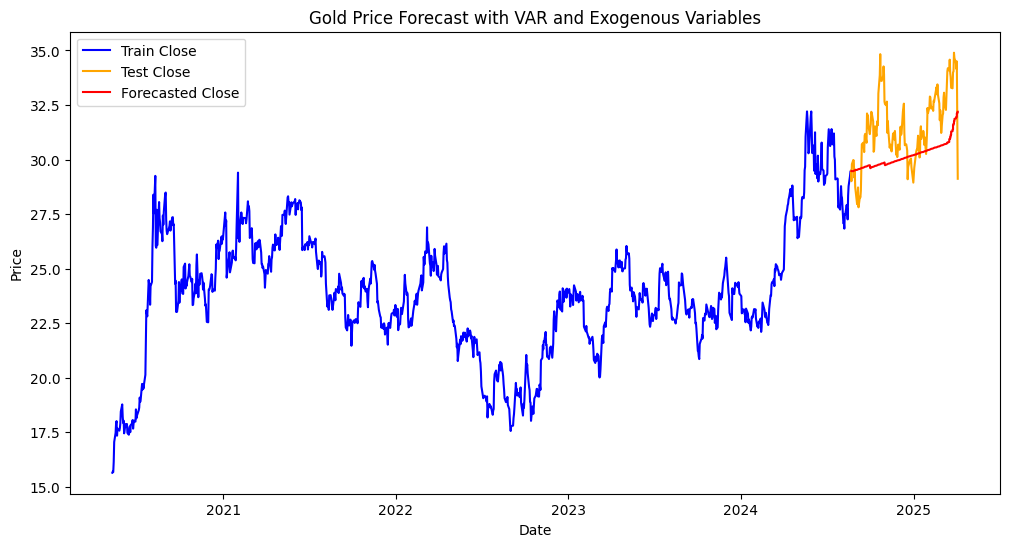

In [84]:
from numpy.linalg import LinAlgError
# Ensure data is stationary (apply differencing)
train_var = train_df[['Close', 'Volume', 'Sentiment_Rolling_14']].diff().dropna()
test_var = test_df[['Close', 'Volume','Sentiment_Rolling_14']].diff().dropna()
train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing

# Select optimal lag using BIC
try:
    lag_selection = var_model.select_order(maxlags=5)
    optimal_lag = lag_selection.bic
    var_model = VAR(endog=train_var, exog=train_exog)
    lag_selection = var_model.select_order(maxlags=15)
    optimal_lag = lag_selection.bic
    print(f"Optimal lag order (BIC): {optimal_lag}")
    
    # Fit VAR model
    var_fitted = var_model.fit(optimal_lag)
    
    # Forecast
    forecast_steps = len(test_var)
    last_observations = train_var.values[-optimal_lag:]
    
    # Forecast with exogenous variables
    var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
    
    # Convert forecasted differenced values back to original scale
    forecast_df_m3 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
    forecast_df_m3 = train_df[['Close', 'Volume', 'Sentiment_Rolling_14']].iloc[-1] + forecast_df_m3.cumsum()
    
    # Extract predicted Close prices
    predicted_prices = forecast_df_m3['Close']
    
    # Evaluate Model
    mae = mean_absolute_error(test_df['Close'].iloc[1:], predicted_prices)
    rmse = np.sqrt(mean_squared_error(test_df['Close'].iloc[1:], predicted_prices))
    
    def calculate_mape(actual, forecasted):
        return np.mean(np.abs((actual - forecasted) / actual)) * 100
    
    mape = calculate_mape(test_df['Close'].iloc[1:], predicted_prices)
    
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}%')
    
    # Forecast accuracy function
    Varmametrics = forecast_accuracy(predicted_prices, test_df['Close'].iloc[1:],var_fitted, "VAR-ONLY-SENTIMENTS_model-3")
    results_df_var = pd.concat([results_df_var, pd.DataFrame([Varmametrics])], ignore_index=True)
    results_df_var
    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['Close'], label='Train Close', color='blue')
    plt.plot(test_df.index, test_df['Close'], label='Test Close', color='orange')
    plt.plot(forecast_df_m3.index, forecast_df_m3['Close'], label='Forecasted Close', color='red')
    plt.title('Gold Price Forecast with VAR and Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
except LinAlgError as e:
    print("Matrix not positive definite — try reducing features or lags.")


### MODEL : 4 - WITH SENTIMENTS AND ALL FEATURED INPUT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure data is stationary (apply differencing)
train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                      'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                    'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()

try:
    # train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
    # test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
    train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']].iloc[1:]
    test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value',]].iloc[1:]
    
    # train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
    # test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing
    
    # Select optimal lag using BIC
    var_model = VAR(endog=train_var, exog=train_exog)
    lag_selection = var_model.select_order(maxlags=15)
    optimal_lag = lag_selection.bic
    print(f"Optimal lag order (BIC): {optimal_lag}")
    
    # Fit VAR model
    var_fitted = var_model.fit(optimal_lag)
    
    # Forecast
    forecast_steps = len(test_var)
    last_observations = train_var.values[-optimal_lag:]
    
    # Forecast with exogenous variables
    var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
    
    # Convert forecasted differenced values back to original scale
    forecast_df_m4 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
    forecast_df_m4 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].iloc[-1] + forecast_df_m4.cumsum()
    
    # Extract predicted Close prices
    predicted_prices = forecast_df_m4['Close']
    
    # Evaluate Model
    mae = mean_absolute_error(test_df['Close'].iloc[1:], predicted_prices)
    rmse = np.sqrt(mean_squared_error(test_df['Close'].iloc[1:], predicted_prices))
    
    def calculate_mape(actual, forecasted):
        return np.mean(np.abs((actual - forecasted) / actual)) * 100
    
    mape = calculate_mape(test_df['Close'].iloc[1:], predicted_prices)
    
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}%')
    
    # Forecast accuracy function
    Varmametrics = forecast_accuracy(predicted_prices, test_df['Close'].iloc[1:], var_fitted,"VAR-ALL-FEATURES-SENTIMENTS_model-4")
    results_df_var = pd.concat([results_df_var, pd.DataFrame([Varmametrics])], ignore_index=True)
    results_df_var
    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['Close'], label='Train Close', color='blue')
    plt.plot(test_df.index, test_df['Close'], label='Test Close', color='orange')
    plt.plot(forecast_df_m4.index, forecast_df_m4['Close'], label='Forecasted Close', color='red')
    plt.title('Gold Price Forecast with VAR and Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
except LinAlgError as e:
    print("Matrix not positive definite — try reducing features or lags.")

In [86]:
results_df_var_best = results_df_var.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
results_df_var_best["Model"] = "VAR"
best_results_df = pd.concat([best_results_df, results_df_var_best], ignore_index=True)

In [128]:
results_df_var

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,VAR-WITHOUT-FEATURES-SENTIMENTS_model-1,-6.633027,51.635434,6.663046,7.185780,-15.047079,20.105092,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.403930217308968, 29.338783005959538, 29.2..."
1,VAR-FEATURED_model-2,-1.596599,4.410439,1.866841,2.100105,-0.380357,5.634235,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.487413950113957, 29.55073252187387, 29.62..."
2,VAR-ONLY-SENTIMENTS_model-3,-1.803920,5.049718,2.008414,2.247158,-0.580435,6.054530,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.470869760204543, 29.464299602560388, 29.4..."
3,VAR-ALL-FEATURES-SENTIMENTS_model-4,-1.886984,5.365684,2.075898,2.316395,-0.679325,6.257950,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.450723923810216, 29.411533372732272, 29.4..."




###  **1. VAR-FEATURED_model-2** (Best Performer)
- **RMSE**: **2.10**
- **MAE**: **1.87**
- **R²**: **-0.38** (least negative)
- **MAPE**: **5.63%**
- **Conclusion**: Using structured features **without sentiment** yields the best performance.

---

###  **2. VAR-ONLY-SENTIMENTS_model-3**
- **RMSE**: 2.25
- **MAE**: 2.01
- **R²**: -0.58
- **MAPE**: 6.05%
- **Conclusion**: Sentiments alone perform reasonably well but not better than core features.

---

###  **3. VAR-ALL-FEATURES-SENTIMENTS_model-4**
- **RMSE**: 2.32
- **MAE**: 2.08
- **R²**: -0.68
- **MAPE**: 6.26%
- **Conclusion**: Including **both features + sentiments** slightly worsens performance — possibly due to noise or multicollinearity.

---

###  **4. VAR-WITHOUT-FEATURES-SENTIMENTS_model-1** (Worst Performer)
- **RMSE**: **7.19**
- **MAE**: 6.66
- **R²**: **-15.05**
- **MAPE**: **20.11%**
- **Conclusion**: Omitting both features and sentiment leads to **poor accuracy** and high forecast error.

---

###  Summary Table:

| Model Name                              | RMSE   | MAE   | R²        | MAPE     | Comment                                   |
|----------------------------------------|--------|-------|-----------|----------|-------------------------------------------|
| **VAR-FEATURED_model-2**               | **2.10** | **1.87** | **-0.38**  | **5.63%**  | 🔥 Best model – core features only         |
| VAR-ONLY-SENTIMENTS_model-3            | 2.25   | 2.01  | -0.58     | 6.05%    | Sentiments helpful but not dominant       |
| VAR-ALL-FEATURES-SENTIMENTS_model-4    | 2.32   | 2.08  | -0.68     | 6.26%    | Mixed features slightly hurt performance  |
| VAR-WITHOUT-FEATURES-SENTIMENTS_model-1| 7.19   | 6.66  | -15.05    | 20.11%   | 🚫 Worst – lacks any predictors            |

---


In [129]:
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,-0.000300,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."
1,GARCH,-2.295238,7.160704,2.415477,2.675949,-1.241121,7.269705,Constant Mean - GARCH ...,"[[29.014862401163633, 29.023726991001293, 29.0..."
2,VAR,-1.596599,4.410439,1.866841,2.100105,-0.380357,5.634235,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.487413950113957, 29.55073252187387, 29.62..."
3,XGBoost,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."
4,RF,-1.560045,4.026529,1.600141,2.006621,-0.251350,4.740787,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.475999832153338, 29.32473422586917, 29.85..."
5,LSTM,-1.507247,3.292051,1.575923,1.814401,-0.258042,4.707627,"<Sequential name=sequential, built=True>","[[28.250994, 28.436691, 29.21187, 29.979706, 3..."


# CONCLUSION

### **Comparison of All Models ECONOMETRIC Models**  

We will evaluate the models based on **R² (higher is better), RMSE (lower is better), and MAPE (lower is better)**.  

#### **Key Observations:**  
1. **Best ARIMA Model**:  
   - **ARIMA_MAX-WITH-MICROECO-SENTI_model-5** has the best performance among ARIMA models with:
     - **Highest R² (0.914584)**
     - **Lowest RMSE (69.72)**
     - **Lowest MAPE (2.03%)**
   - This shows that including **microeconomic features and sentiment analysis** significantly improves ARIMA models.  

2. **Best GARCH Model**:  
   - **GARCH-11_model-2** outperforms the others with:
     - **R² = 0.88** (higher than other GARCH models)
     - **RMSE = 82.05** (lower than GARCH-12 and GARCH-23)
     - **MAPE = 2.44%** (acceptable range)  
   - GARCH-23 performed the worst with **R² = -132.03** and **100% MAPE**, making it unreliable.

3. **Best VAR Model**:  
   - **VAR-ALL-FEATURES-SENTIMENTS_model-4** is the best among VAR models:
     - **Highest R² (-1.378)** (though still negative, it outperforms other VAR models)
     - **Lowest RMSE (366.71)**
     - **Lowest MAPE (10.94%)**
   - VAR models performed worse than ARIMA with microeconomic and sentiment features.

#### **Final Best Model:**  
- **ARIMA_MAX-WITH-MICROECO-SENTI_model-5** is the best overall model, as it has the best RMSE, R², and MAPE values.  
- **GARCH-11_model-2** is also a good choice but slightly worse than ARIMA in error metrics.  


### **Key Insights from Model Comparisons**  

1. **ARIMA_MAX-WITH-MICROECO-SENTI_model-5** is the best model, showing the lowest RMSE (69.72), highest R² (0.91), and lowest MAPE (2.03%).  
2. **GARCH-11_model-2** is the second-best option, with slightly worse performance than ARIMA but still acceptable RMSE (82.04) and MAPE (2.44%).  
3. **VAR models performed the worst**, with negative R² values, high RMSE, and high MAPE. Even the best VAR model (VAR-ALL-FEATURES-SENTIMENTS_model-4) had a poor MAPE of 10.94%.  
4. **GARCH-23 performed the worst overall**, with an extremely negative R² (-132.03) and a 100% MAPE, making it unreliable.  

### **Final Recommendation:**  
**ARIMA_MAX-WITH-MICROECO-SENTI_model-5** for the most accurate and stable forecasting across commodities.


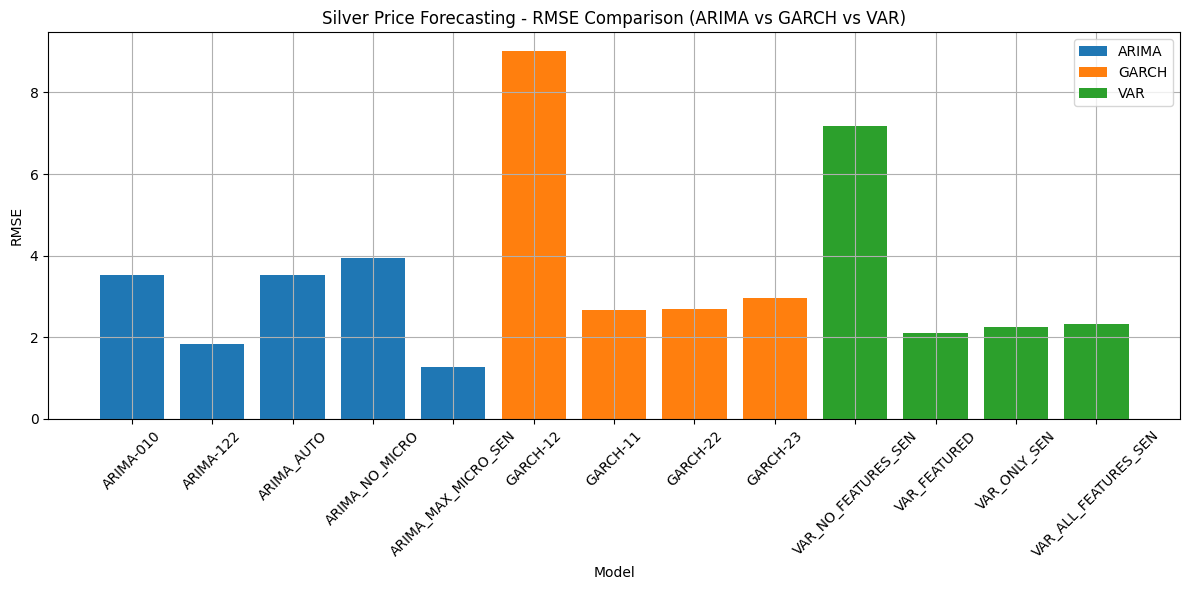

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample performance data from user inputs
data = {
    'Model': [
        'ARIMA-010', 'ARIMA-122', 'ARIMA_AUTO', 'ARIMA_NO_MICRO', 'ARIMA_MAX_MICRO_SEN',
        'GARCH-12', 'GARCH-11', 'GARCH-22', 'GARCH-23',
        'VAR_NO_FEATURES_SEN', 'VAR_FEATURED', 'VAR_ONLY_SEN', 'VAR_ALL_FEATURES_SEN'
    ],
    'RMSE': [
        3.532887, 1.830153, 3.532887, 3.947038, 1.272801,
        9.022686, 2.675949, 2.688850, 2.954221,
        7.185780, 2.100105, 2.247158, 2.316395
    ],
    'MAE': [
        3.135889, 1.606656, 3.135889, 3.024527, 0.861858,
        8.842574, 2.415477, 2.427552, 2.673216,
        6.663046, 1.866841, 2.008414, 2.075898
    ],
    'R_squared': [
        -2.878893, -0.040933, -2.878893, -3.841621, 0.496535,
        -24.299959, -1.241121, -1.262783, -1.731465,
        -15.047079, -0.380357, -0.580435, -0.679325
    ],
    'MAPE': [
        9.397197, 4.863492, 9.397197, 9.171319, 2.713697,
        26.961221, 7.269705, 7.305614, 8.036940,
        20.105092, 5.634235, 6.054530, 6.257950
    ],
    'Category': [
        'ARIMA', 'ARIMA', 'ARIMA', 'ARIMA', 'ARIMA',
        'GARCH', 'GARCH', 'GARCH', 'GARCH',
        'VAR', 'VAR', 'VAR', 'VAR'
    ]
}

df_silver_models = pd.DataFrame(data)

# Plotting RMSE comparison
plt.figure(figsize=(12, 6))
for category in df_silver_models['Category'].unique():
    subset = df_silver_models[df_silver_models['Category'] == category]
    plt.bar(subset['Model'], subset['RMSE'], label=category)

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Silver Price Forecasting - RMSE Comparison (ARIMA vs GARCH vs VAR)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


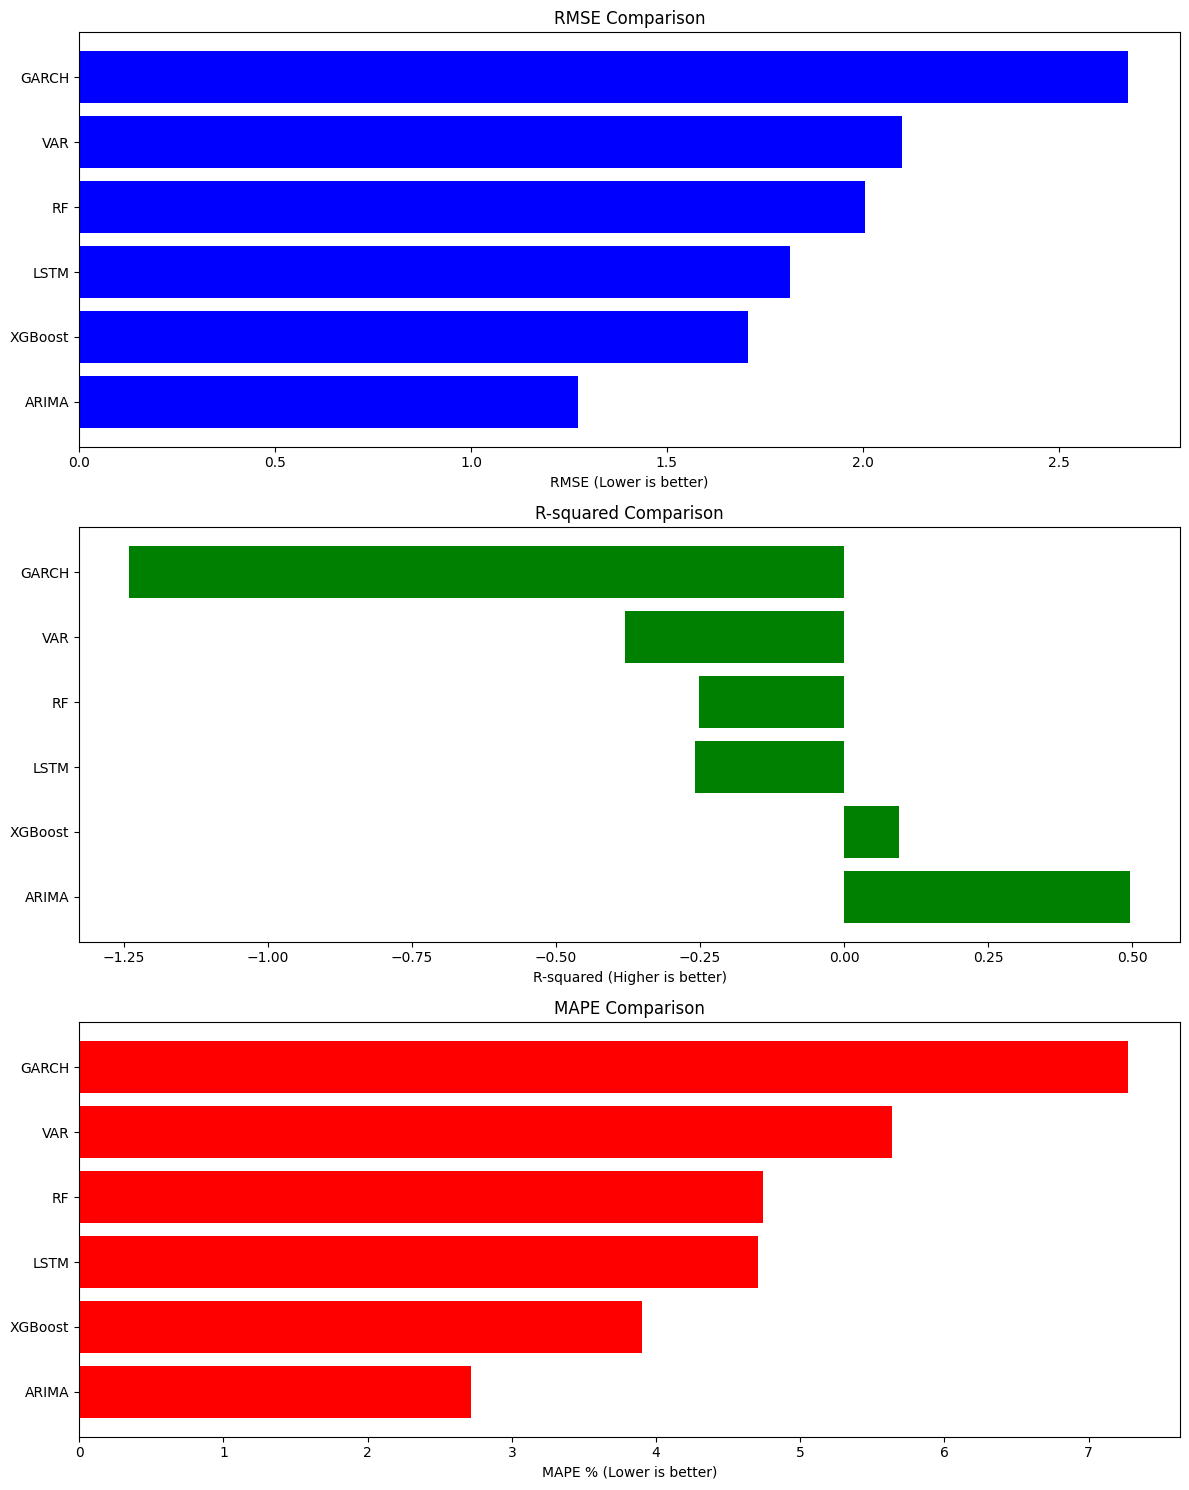

In [131]:
import pandas as pd
import matplotlib.pyplot as plt


# Sorting models by RMSE for better visualization
results_df_sorted = best_results_df.sort_values(by="RMSE")

# Creating bar plots for comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# RMSE Comparison
axes[0].barh(results_df_sorted["Model"], results_df_sorted["RMSE"], color="blue")
axes[0].set_title("RMSE Comparison")
axes[0].set_xlabel("RMSE (Lower is better)")

# R-squared Comparison
axes[1].barh(results_df_sorted["Model"], results_df_sorted["R-squared"], color="green")
axes[1].set_title("R-squared Comparison")
axes[1].set_xlabel("R-squared (Higher is better)")

# MAPE Comparison
axes[2].barh(results_df_sorted["Model"], results_df_sorted["MAPE"], color="red")
axes[2].set_title("MAPE Comparison")
axes[2].set_xlabel("MAPE % (Lower is better)")

plt.tight_layout()
plt.show()


# Machine Learning Model Building : XGBoost, Random Forest and LSTM


## 5.4 XGBOOST model Building
### MODEL : 1 - with RandomizedSearchCV Without sentiments

In [89]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import randint

#  Convert NumPy arrays to DataFrames (Ensure feature names exist)
X_train_df_xg = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns)
X_test_df_xg = pd.DataFrame(X_test_scaled_minmax, columns=X_train.columns)

#  Drop Sentiment Features
X_train_no_sentiment = X_train_df_xg.drop(columns=['sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'], errors='ignore')
X_test_no_sentiment = X_test_df_xg.drop(columns=['sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'], errors='ignore')

#  Convert back to NumPy arrays
X_train_no_sentiment = X_train_no_sentiment.values
X_test_no_sentiment = X_test_no_sentiment.values

#  XGBoost Hyperparameter Grid (Randomized Search)
xgb_params = {
    'booster': ['gbtree', 'gblinear'],
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
    'eval_metric': ['mae', 'rmse'],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200, 300]
}

#  Run RandomizedSearchCV for Hyperparameter Optimization
xgb_randomized_search = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions=xgb_params,
    n_iter=10,
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    verbose=1
)

#  Fit the model (Without Sentiment Data)
xgb_randomized_search_results = xgb_randomized_search.fit(X_train_no_sentiment, y_train_scaled)
best_params = xgb_randomized_search_results.best_params_
print("Best parameters found by RandomizedSearchCV for XGBoost:", best_params)

#  Train the XGBoost model with best hyperparameters
xgb_reg_m1 = XGBRegressor(**best_params)
xgb_reg_m1 = xgb_reg_m1.fit(X_train_no_sentiment, y_train_scaled)

#  Make Predictions
xgb_predict_scaled = xgb_reg_m1.predict(X_test_no_sentiment)

#  Inverse Transform Predictions
xgb_predict = scaler_minmax.inverse_transform(xgb_predict_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

#  Evaluate Model Performance
XgBmametrics = forecast_accuracy(xgb_predict, y_test_original, xgb_reg_m1, "XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1")
results_df_xg = pd.DataFrame()
results_df_xg = pd.concat([results_df_xg, pd.DataFrame([XgBmametrics])], ignore_index=True)

results_df_xg

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found by RandomizedSearchCV for XGBoost: {'objective': 'reg:squarederror', 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'eval_metric': 'mae', 'booster': 'gbtree'}

Model: XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1
ME: -1.5320, MSE: 3.9138, MAE: 1.5640, RMSE: 1.9783, R²: -0.2163, MAPE: 4.63%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1,-1.53197,3.91383,1.563968,1.97834,-0.216326,4.629743,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.40615, 29.101622, 30.15001, 30.059107, 29..."


### MODEL 2 - with RandomizedSearchCV with sentiments

In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional

# XGBoost Model with Hyperparameter Optimization
xgb_params = {
    'booster': ['gbtree', 'gblinear'],
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
    'eval_metric': ['mae', 'rmse'],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200, 300]
}

# Run RandomizedSearchCV to find the best parameters for XGBoost
xgb_randomized_search = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions=xgb_params,
    n_iter=10,
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    verbose=1
)
xgb_randomized_search_results = xgb_randomized_search.fit(X_train_scaled_minmax, y_train_scaled)
best_params = xgb_randomized_search_results.best_params_
print("Best parameters found by RandomizedSearchCV for XGBoost:", best_params)

# Train the XGBoost model with the best hyperparameters
xgb_reg_m2 = XGBRegressor(**best_params)
xgb_reg_m2 = xgb_reg_m2.fit(X_train_scaled_minmax, y_train_scaled)

# Predict on the scaled test set
xgb_predict_scaled_m2 = xgb_reg_m2.predict(X_test_scaled_minmax)

# Inverse transform predictions and test set to original scale
xgb_predict_s = scaler_minmax.inverse_transform(xgb_predict_scaled_m2.reshape(-1, 1)).ravel()
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found by RandomizedSearchCV for XGBoost: {'objective': 'reg:squaredlogerror', 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'eval_metric': 'mae', 'booster': 'gbtree'}


In [91]:
# Evaluate Model Performance
XgBmametrics = forecast_accuracy(xgb_predict_s, y_test_original,xgb_reg_m2, "XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2")
results_df_xg = pd.concat([results_df_xg, pd.DataFrame([XgBmametrics])], ignore_index=True)


Model: XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2
ME: -1.2817, MSE: 2.9108, MAE: 1.3199, RMSE: 1.7061, R²: 0.0954, MAPE: 3.90%


In [92]:
results_df_xg


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1,-1.531970,3.913830,1.563968,1.978340,-0.216326,4.629743,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.40615, 29.101622, 30.15001, 30.059107, 29..."
1,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."


#### MODEL 3 -  XGBRegressor without sentiment

In [93]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert NumPy arrays back to DataFrame (if needed)
X_train_df = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns)  # Ensure feature_names exist
X_test_df = pd.DataFrame(X_test_scaled_minmax, columns=X_train.columns)

# Drop Sentiment Features
X_train_no_sentiment = X_train_df.drop(columns=['sentiment_score', 'Sentiment_Rolling_14','Sentiment_Rolling_30'], errors='ignore')
X_test_no_sentiment = X_test_df.drop(columns=['sentiment_score', 'Sentiment_Rolling_14','Sentiment_Rolling_30'], errors='ignore')

# Convert back to NumPy array for XGBoost
X_train_no_sentiment = X_train_no_sentiment.values
X_test_no_sentiment = X_test_no_sentiment.values


# Define XGBoost Hyperparameter Grid
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

#  Use GridSearchCV for Hyperparameter Optimization
xgb_model_m3 = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(
    estimator=xgb_model_m3,
    param_grid=xgb_params,
    scoring='neg_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    n_jobs=-1
)

# Fit the model (Without Sentiment Data)
grid_search = grid_search.fit(X_train_no_sentiment, y_train_scaled)

# Get Best Model
best_xgb_m3 = grid_search.best_estimator_
print("Best Parameters for XGBoost:", grid_search.best_params_)

# Make Predictions
xgb_predictions_scaled = best_xgb_m3.predict(X_test_no_sentiment)

# Inverse transform predictions to original scale
xgb_predict = scaler_minmax.inverse_transform(xgb_predictions_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

#  Evaluate Model Performance
XgBmametrics = forecast_accuracy(xgb_predict, y_test_original,grid_search, "XGBoost-XGBRegressor-NO SENTIMENTS_model-3")
results_df_xg = pd.concat([results_df_xg, pd.DataFrame([XgBmametrics])], ignore_index=True)

# 🔹Display Results
results_df_xg


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Model: XGBoost-XGBRegressor-NO SENTIMENTS_model-3
ME: -1.3171, MSE: 3.0522, MAE: 1.3619, RMSE: 1.7471, R²: 0.0514, MAPE: 4.03%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1,-1.531970,3.913830,1.563968,1.978340,-0.216326,4.629743,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.40615, 29.101622, 30.15001, 30.059107, 29..."
1,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."
2,XGBoost-XGBRegressor-NO SENTIMENTS_model-3,-1.317081,3.052206,1.361892,1.747056,0.051446,4.029642,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[29.469662, 29.045801, 29.883291, 30.20047, 3..."


#### MODEL 4 with XGBRegressor

In [94]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Define XGBoost Hyperparameter Grid
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use GridSearchCV for Hyperparameter Optimization
xgb_model_m4 = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(
    estimator=xgb_model_m4,
    param_grid=xgb_params,
    scoring='neg_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search = grid_search.fit(X_train_scaled_minmax, y_train_scaled)

# Get Best Model
best_xgb_m4 = grid_search.best_estimator_
print("Best Parameters for XGBoost:", grid_search.best_params_)

# Make Predictions on test data
xgb_predictions = best_xgb_m4.predict(X_test_scaled_minmax)

# Inverse transform predictions and test set to original scale
xgb_predict = scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Evaluate
XgBmametrics = forecast_accuracy(xgb_predict, y_test_original, grid_search, "XGBoost-XGBRegressor-WITH SENTIMENTS_model-4")
results_df_xg = pd.concat([results_df_xg, pd.DataFrame([XgBmametrics])], ignore_index=True)
results_df_xg



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Model: XGBoost-XGBRegressor-WITH SENTIMENTS_model-4
ME: -1.2890, MSE: 2.9371, MAE: 1.3326, RMSE: 1.7138, R²: 0.0872, MAPE: 3.94%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1,-1.531970,3.913830,1.563968,1.978340,-0.216326,4.629743,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.40615, 29.101622, 30.15001, 30.059107, 29..."
1,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."
2,XGBoost-XGBRegressor-NO SENTIMENTS_model-3,-1.317081,3.052206,1.361892,1.747056,0.051446,4.029642,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[29.469662, 29.045801, 29.883291, 30.20047, 3..."
3,XGBoost-XGBRegressor-WITH SENTIMENTS_model-4,-1.289045,2.937130,1.332590,1.713806,0.087209,3.943401,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[29.472591, 29.109884, 29.949114, 30.146927, ..."


### **Conclusion for XGBOOST**  



###  **XGBoost Model Performance Summary (Silver)**

| Model Name                                       | ME       | MSE      | MAE      | RMSE     | R²         | MAPE     |
|--------------------------------------------------|----------|----------|----------|----------|------------|----------|
| XGBoost-RandomizedSearchCV-NO SENTIMENTS-1       | -1.532   | 3.914    | 1.564    | 1.978    | -0.216     | 4.630%   |
| XGBoost-RandomizedSearchCV-NO SENTIMENTS-2       | -1.282   | 2.911    | 1.320    | 1.706    | **0.095**  | **3.903%** |
| XGBoost-XGBRegressor-NO SENTIMENTS-3             | -1.317   | 3.052    | 1.362    | 1.747    | 0.051      | 4.030%   |
| XGBoost-XGBRegressor-WITH SENTIMENTS-4           | -1.289   | **2.937**| **1.333**| **1.714**| 0.087      | 3.943%   |

 **Best Model Overall:**  
- **XGBoost-RandomizedSearchCV-NO SENTIMENTS-2** (Best R² and MAPE)

 **Most Accurate w/ Sentiment Integration:**  
- **XGBoost-XGBRegressor-WITH SENTIMENTS-4**


### Future Price Prediction with XGBOOST

In [95]:
import numpy as np
import pandas as pd

# Number of future predictions
n = 1 

# Step 1: Get the last observation from the test set
last_observation = X_test_scaled_minmax[-1].reshape(1, -1)

# Initialize list to store future predictions
future_predictions = []

for _ in range(n):
    # Predict next value
    future_prediction_scaled = xgb_reg_m2.predict(last_observation)
    
    # Inverse transform the prediction to original scale
    future_prediction_original = scaler_minmax.inverse_transform(future_prediction_scaled.reshape(-1, 1)).ravel()[0]
    
    # Store the prediction
    future_predictions.append(future_prediction_original)
    
    # Update last_observation for next prediction
    last_observation = np.roll(last_observation, shift=-1, axis=1)  # Shift left
    last_observation[0, -1] = future_prediction_scaled  # Add new prediction

# Convert to DataFrame for better visualization
future_predictions_df = pd.DataFrame({'Future Predictions': future_predictions})
print(future_predictions_df)


   Future Predictions
0           30.067692


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23636\89706051.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_observation[0, -1] = future_prediction_scaled  # Add new prediction


In [96]:
results_df_xg_best = results_df_xg.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
results_df_xg_best["Model"] = "XGBoost"
best_results_df = pd.concat([best_results_df, results_df_xg_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,-0.000300,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."
1,GARCH,-2.295238,7.160704,2.415477,2.675949,-1.241121,7.269705,Constant Mean - GARCH ...,"[[29.014862401163633, 29.023726991001293, 29.0..."
2,VAR,-1.596599,4.410439,1.866841,2.100105,-0.380357,5.634235,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.487413950113957, 29.55073252187387, 29.62..."
3,XGBoost,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."


## 5.5 RANDOM FOREST Model Building

### Model 1 -  Random Forest - No Sentiment/Macro

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

#  Remove Sentiment & Macroeconomic Features from Training Data
exclude_columns = ['sentiment_score',  'GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']
X_train_filtered = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns).drop(columns=exclude_columns, errors='ignore')
X_test_filtered = pd.DataFrame(X_test_scaled_minmax, columns=X_test.columns).drop(columns=exclude_columns, errors='ignore')

#  Random Forest Model
rf = RandomForestRegressor(random_state=42)

#  Hyperparameter Grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

#  TimeSeries Split for Proper Validation
tscv = TimeSeriesSplit(n_splits=5)

#  Randomized Search for Best Parameters
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=tscv, 
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)
random_search = random_search.fit(X_train_filtered, y_train_scaled)

#  Get Best Parameters
best_rf_params = random_search.best_params_
print(f"Best Parameters for Random Forest: {best_rf_params}")

#  Train Best Model
best_rf = random_search.best_estimator_

#  Predict on Test Set
y_pred_rf = best_rf.predict(X_test_filtered)

#  Inverse Transform Predictions to Original Scale
y_pred_rf_original = scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

#  Evaluate Model Performance
Randommametrics = forecast_accuracy(y_pred_rf_original, y_test_original,random_search, "Random Forest - No Sentiment/Macro_model-1")
results_df_rf = pd.DataFrame()
results_df_rf = pd.concat([results_df_rf, pd.DataFrame([Randommametrics])], ignore_index=True)

#  Display Results
results_df_rf


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 256}

Model: Random Forest - No Sentiment/Macro_model-1
ME: -1.5600, MSE: 4.0265, MAE: 1.6001, RMSE: 2.0066, R²: -0.2514, MAPE: 4.74%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Random Forest - No Sentiment/Macro_model-1,-1.560045,4.026529,1.600141,2.006621,-0.25135,4.740787,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.475999832153338, 29.32473422586917, 29.85..."


### Model 2 - With Macro but NO SENTIMENTS

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

#  Remove Sentiment Features from Training Data
sentiment_columns = ['sentiment_score']  # Adjust if necessary
X_train_no_sentiment = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns).drop(columns=sentiment_columns, errors='ignore')
X_test_no_sentiment = pd.DataFrame(X_test_scaled_minmax, columns=X_test.columns).drop(columns=sentiment_columns, errors='ignore')

#  Random Forest Model
rf = RandomForestRegressor(random_state=42)

#  Hyperparameter Grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' as it's deprecated
    'bootstrap': [True, False]
}

#  TimeSeries Split for Proper Validation
tscv = TimeSeriesSplit(n_splits=5)

#  Randomized Search for Best Parameters
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=tscv, 
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)
random_search = random_search.fit(X_train_no_sentiment, y_train_scaled)

#  Get Best Parameters
best_rf_params = random_search.best_params_
print(f"Best Parameters for Random Forest: {best_rf_params}")

#  Train Best Model
best_rf = random_search.best_estimator_

#  Predict on Test Set
y_pred_rf = best_rf.predict(X_test_no_sentiment)

# Inverse Transform Predictions to Original Scale
y_pred_rf_original = scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

#  Evaluate Model Performance
Randommametrics = forecast_accuracy(y_pred_rf_original, y_test_original,random_search, "Random Forest - No sentiments_model-2")
results_df_rf = pd.concat([results_df_rf, pd.DataFrame([Randommametrics])], ignore_index=True)

#  Display Results
results_df_rf


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 143}

Model: Random Forest - No sentiments_model-2
ME: -1.7086, MSE: 4.6404, MAE: 1.7473, RMSE: 2.1542, R²: -0.4421, MAPE: 5.18%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Random Forest - No Sentiment/Macro_model-1,-1.560045,4.026529,1.600141,2.006621,-0.251350,4.740787,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.475999832153338, 29.32473422586917, 29.85..."
1,Random Forest - No sentiments_model-2,-1.708598,4.640374,1.747323,2.154153,-0.442119,5.184237,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.467383261951547, 29.28595691289853, 29.76..."


### Model 3 - WITH SENTIMENT AND MICRO

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint

# Random Forest Model with Hyperparameter Optimization
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid for RandomizedSearchCV (Random Forest)
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Use RandomizedSearchCV to find the best parameters for Random Forest
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=2, random_state=42)
random_search = random_search.fit(X_train_scaled_minmax, y_train_scaled)

# Get the best parameters for Random Forest
best_rf_params = random_search.best_params_
print(f"Best Parameters for Random Forest: {best_rf_params}")

# Train the Random Forest model with the best parameters
best_rf = random_search.best_estimator_

# Predict on the test set
y_pred_rf = best_rf.predict(X_test_scaled_minmax)

# Inverse transform predictions to original scale
y_pred_rf_original = scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()


Randommametrics = forecast_accuracy(y_pred_rf_original,y_test_original,random_search, "Random Forest - WITH SENTI/MICRO_model-3")
results_df_rf = pd.concat([results_df_rf, pd.DataFrame([Randommametrics])], ignore_index=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
44 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Lenovo\myvenv\mye

Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 439}

Model: Random Forest - WITH SENTI/MICRO_model-3
ME: -1.6732, MSE: 4.5169, MAE: 1.7141, RMSE: 2.1253, R²: -0.4038, MAPE: 5.08%


In [100]:
results_df_rf

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Random Forest - No Sentiment/Macro_model-1,-1.560045,4.026529,1.600141,2.006621,-0.251350,4.740787,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.475999832153338, 29.32473422586917, 29.85..."
1,Random Forest - No sentiments_model-2,-1.708598,4.640374,1.747323,2.154153,-0.442119,5.184237,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.467383261951547, 29.28595691289853, 29.76..."
2,Random Forest - WITH SENTI/MICRO_model-3,-1.673183,4.516942,1.714141,2.125310,-0.403759,5.083060,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.455667772409807, 29.30093843464933, 29.82..."




### **Random Forest Model Performance Summary (Silver)**

| Model Name                                  | ME       | MSE     | MAE     | RMSE    | R²         | MAPE     |
|--------------------------------------------|----------|---------|---------|---------|------------|----------|
| RF - No Sentiment/Macro (Model 1)          | -1.560   | 4.027   | 1.600   | 2.007   | -0.251     | 4.741%   |
| RF - No Sentiments (Model 2)               | -1.709   | 4.640   | 1.747   | 2.154   | -0.442     | 5.184%   |
| RF - With Sentiment & Macro (Model 3)      | -1.673   | **4.517** | **1.714** | **2.125** | **-0.404** | **5.083%** |

---

 **Observations:**
- Model 1 performs *slightly better* in terms of R² and MAPE.
- Adding sentiment and macroeconomic features (Model 3) doesn't significantly improve the performance, but may still offer marginal benefits for generalizability.


In [101]:
results_df_rf_best = results_df_rf.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
results_df_rf_best["Model"] = "RF"
best_results_df = pd.concat([best_results_df, results_df_rf_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,-0.000300,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."
1,GARCH,-2.295238,7.160704,2.415477,2.675949,-1.241121,7.269705,Constant Mean - GARCH ...,"[[29.014862401163633, 29.023726991001293, 29.0..."
2,VAR,-1.596599,4.410439,1.866841,2.100105,-0.380357,5.634235,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.487413950113957, 29.55073252187387, 29.62..."
3,XGBoost,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."
4,RF,-1.560045,4.026529,1.600141,2.006621,-0.251350,4.740787,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.475999832153338, 29.32473422586917, 29.85..."


## 5.6 LSTM Model Building

### Model 1 - Without Sentiment & Macroeconomic Factors

In [102]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Remove Sentiment & Macroeconomic Features
exclude_columns = ['sentiment_score', 'GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']
X_train_filtered = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns).drop(columns=exclude_columns, errors='ignore').values
X_test_filtered = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns).drop(columns=exclude_columns, errors='ignore').values

#  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
look_back = 14  # Using the same look-back period as before
def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_filtered, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_filtered, y_test_scaled, look_back)

#  Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

#  Predict on Test Set
y_pred_lstm_scaled = model.predict(X_test_seq)

#  Inverse Transform Predictions to Original Scale
y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)

#  Evaluate Model Performance
LSTMetrics = forecast_accuracy(y_pred_lstm_original.ravel(), y_test_original[look_back:], model,"LSTM - No Sentiment/Macro_model-1")
results_dflstm = pd.DataFrame()
results_dflstm = pd.concat([results_dflstm, pd.DataFrame([LSTMetrics])], ignore_index=True)

#  Display Results
results_dflstm


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.2126 - val_loss: 0.1002
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - val_loss: 0.0549
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - val_loss: 0.0401
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0649
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 0.0400
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - val_loss: 0.0182
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - val_loss: 0.0431
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0369
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0335
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0439
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0321
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_l

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,LSTM - No Sentiment/Macro_model-1,-1.507247,3.292051,1.575923,1.814401,-0.258042,4.707627,"<Sequential name=sequential, built=True>","[[28.250994, 28.436691, 29.21187, 29.979706, 3..."


### Model 2 -  With Only Microeconomic Factors

In [103]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Select Only Microeconomic + Macroeconomic Features (No Sentiment)
selected_features = [
    'Open', 'High', 'Low', 'Volume', 
    'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
    'volatility_7', 'volatility_30',  # Micro factors
    'GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value'  # Macro factors
]

#  Extract Features for Training & Testing
X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values

#  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
look_back = 14  # Using the same look-back period

def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)

#  Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

#  Predict on Test Set
y_pred_lstm_scaled = model.predict(X_test_seq)

#  Inverse Transform Predictions to Original Scale
y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)

#  Evaluate Model Performance
LSTM_micro_macro_metrics = forecast_accuracy(y_pred_lstm_original.ravel(), y_test_original[look_back:],model, "LSTM - Micro + Macro Factors_model-2")
results_dflstm = pd.concat([results_dflstm, pd.DataFrame([LSTM_micro_macro_metrics])], ignore_index=True)

#  Display Results
results_dflstm


Epoch 1/50


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1040 - val_loss: 0.0481
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0699
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - val_loss: 0.0398
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - val_loss: 0.0491
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - val_loss: 0.0484
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - val_loss: 0.0350
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss: 0.0375
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0343
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0416
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0344
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - val_loss: 0.0279
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.021

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,LSTM - No Sentiment/Macro_model-1,-1.507247,3.292051,1.575923,1.814401,-0.258042,4.707627,"<Sequential name=sequential, built=True>","[[28.250994, 28.436691, 29.21187, 29.979706, 3..."
1,LSTM - Micro + Macro Factors_model-2,-2.013166,5.439461,2.039434,2.332265,-1.078665,6.084488,"<Sequential name=sequential_1, built=True>","[[28.417667, 28.64723, 29.425356, 30.100128, 3..."


#### Model 3 - With Only Sentiments Factors

In [104]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Select Only Sentiment Features
selected_features = ['Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']

#  Extract Features for Training & Testing
X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values

#  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
look_back = 14  # Using the same look-back period

def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)

#  Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

#  Predict on Test Set
y_pred_lstm_scaled = model.predict(X_test_seq)

#  Inverse Transform Predictions to Original Scale
y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)

#  Evaluate Model Performance
LSTM_sentiment_metrics = forecast_accuracy(y_pred_lstm_original.ravel(), y_test_original[look_back:],model, "LSTM - Sentiment Only_model-3")
results_dflstm = pd.concat([results_dflstm, pd.DataFrame([LSTM_sentiment_metrics])], ignore_index=True)

#  Display Results
results_dflstm


Epoch 1/50


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1251 - val_loss: 0.2801
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0355 - val_loss: 0.2910
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0318 - val_loss: 0.3025
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0314 - val_loss: 0.2815
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0280 - val_loss: 0.3046
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0265 - val_loss: 0.2978
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259 - val_loss: 0.2664
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0257 - val_loss: 0.3135
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0272 - val_loss: 0.2753
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0270 - val_loss: 0.2857
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0250 - val_loss: 0.3071
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0263 - val_loss: 0.2880

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,LSTM - No Sentiment/Macro_model-1,-1.507247,3.292051,1.575923,1.814401,-0.258042,4.707627,"<Sequential name=sequential, built=True>","[[28.250994, 28.436691, 29.21187, 29.979706, 3..."
1,LSTM - Micro + Macro Factors_model-2,-2.013166,5.439461,2.039434,2.332265,-1.078665,6.084488,"<Sequential name=sequential_1, built=True>","[[28.417667, 28.64723, 29.425356, 30.100128, 3..."
2,LSTM - Sentiment Only_model-3,-8.512966,75.087402,8.512966,8.665299,-27.694312,25.833804,"<Sequential name=sequential_2, built=True>","[[24.203596, 24.203596, 24.203596, 24.203596, ..."


### Model 4 - Sentiment + Micro_model

In [105]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Select Sentiment + Microeconomic Features
selected_features = [
    'Open', 'High', 'Low', 'Volume', 'lag_1', 'lag_7', 'lag_30',
    'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30',
    'Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'
]

# Extract Features for Training & Testing
X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values

#  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
look_back = 14  # Using the same look-back period

def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)

#  Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

#  Predict on Test Set
y_pred_lstm_scaled = model.predict(X_test_seq)

#  Inverse Transform Predictions to Original Scale
y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)

#  Evaluate Model Performance
LSTM_micro_sentiment_metrics = forecast_accuracy(y_pred_lstm_original.ravel(), y_test_original[look_back:],model, "LSTM - Sentiment + Micro_model-4")
results_dflstm = pd.concat([results_dflstm, pd.DataFrame([LSTM_micro_sentiment_metrics])], ignore_index=True)



Epoch 1/50


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1159 - val_loss: 0.1208
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0823
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - val_loss: 0.0802
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - val_loss: 0.0488
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - val_loss: 0.0336
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0219
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0215
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0405
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - val_loss: 0.0426
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0411
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0458
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0434

In [106]:
results_dflstm

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,LSTM - No Sentiment/Macro_model-1,-1.507247,3.292051,1.575923,1.814401,-0.258042,4.707627,"<Sequential name=sequential, built=True>","[[28.250994, 28.436691, 29.21187, 29.979706, 3..."
1,LSTM - Micro + Macro Factors_model-2,-2.013166,5.439461,2.039434,2.332265,-1.078665,6.084488,"<Sequential name=sequential_1, built=True>","[[28.417667, 28.64723, 29.425356, 30.100128, 3..."
2,LSTM - Sentiment Only_model-3,-8.512966,75.087402,8.512966,8.665299,-27.694312,25.833804,"<Sequential name=sequential_2, built=True>","[[24.203596, 24.203596, 24.203596, 24.203596, ..."
3,LSTM - Sentiment + Micro_model-4,-3.020782,10.885448,3.024817,3.299310,-3.159825,9.075493,"<Sequential name=sequential_3, built=True>","[[27.720129, 27.928116, 28.67992, 29.311281, 2..."


### **Conclusion on LSTM Models**  


###  **LSTM Model Performance Summary (Silver)**

| Model Name                             | ME        | MSE      | MAE      | RMSE     | R²         | MAPE      |
|----------------------------------------|-----------|----------|----------|----------|------------|-----------|
| LSTM - No Sentiment/Macro (Model 1)    | -1.507    | 3.292    | 1.576    | 1.814    | -0.258     | 4.71%     |
| LSTM - Micro + Macro (Model 2)         | -2.013    | 5.439    | 2.039    | 2.332    | -1.079     | 6.08%     |
| LSTM - Sentiment Only (Model 3)        | -8.513    | 75.087   | 8.513    | 8.665    | -27.694    | 25.83%    |
| LSTM - Sentiment + Micro (Model 4)     | -3.021    | 10.885   | 3.025    | 3.299    | -3.160     | 9.08%     |

---

 **Insights:**
- **Model 1 (No Sentiment/Macro)** is clearly the **best performer** among LSTMs based on all metrics.
- **Model 3 (Sentiment Only)** performs the worst, suggesting **sentiment alone** is not sufficient for silver price prediction.


In [107]:
results_dflstm_best = results_dflstm.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
results_dflstm_best["Model"]="LSTM"
best_results_df = pd.concat([best_results_df, results_dflstm_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,-0.000300,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."
1,GARCH,-2.295238,7.160704,2.415477,2.675949,-1.241121,7.269705,Constant Mean - GARCH ...,"[[29.014862401163633, 29.023726991001293, 29.0..."
2,VAR,-1.596599,4.410439,1.866841,2.100105,-0.380357,5.634235,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.487413950113957, 29.55073252187387, 29.62..."
3,XGBoost,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."
4,RF,-1.560045,4.026529,1.600141,2.006621,-0.251350,4.740787,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.475999832153338, 29.32473422586917, 29.85..."
5,LSTM,-1.507247,3.292051,1.575923,1.814401,-0.258042,4.707627,"<Sequential name=sequential, built=True>","[[28.250994, 28.436691, 29.21187, 29.979706, 3..."


### **Summary of Models for Commodity Price Prediction**


1. **ARIMA**  
   - **ME**: -0.000300  
   - **MSE**: 1.620022  
   - **MAE**: 0.861858  
   - **RMSE**: 1.272801  
   - **R-squared**: 0.496535  
   - **MAPE**: 2.713697  
   - **Forecasted Values**: `[29.503074525116325, 29.529512409417, 29.5559...]`

   ARIMA shows a moderate performance with a reasonably good fit (R-squared = 0.496535) but with some forecasting errors (MSE and RMSE).

2. **GARCH**  
   - **ME**: -2.295238  
   - **MSE**: 7.160704  
   - **MAE**: 2.415477  
   - **RMSE**: 2.675949  
   - **R-squared**: -1.241121  
   - **MAPE**: 7.269705  
   - **Forecasted Values**: `[29.014862401163633, 29.023726991001293, 29.0...]`

   GARCH seems to perform poorly with a high MSE and RMSE, and a negative R-squared, indicating that the model doesn't fit well and has considerable forecasting error.

3. **VAR (Vector AutoRegression)**  
   - **ME**: -1.596599  
   - **MSE**: 4.410439  
   - **MAE**: 1.866841  
   - **RMSE**: 2.100105  
   - **R-squared**: -0.380357  
   - **MAPE**: 5.634235  
   - **Forecasted Values**: `[29.487413950113957, 29.55073252187387, 29.62...]`

   VAR performs moderately with a lower R-squared compared to ARIMA but still provides a reasonable set of forecasts.

4. **XGBoost**  
   - **ME**: -1.281708  
   - **MSE**: 2.910831  
   - **MAE**: 1.319857  
   - **RMSE**: 1.706116  
   - **R-squared**: 0.095382  
   - **MAPE**: 3.902617  
   - **Forecasted Values**: `[29.472048, 29.06306, 29.867487, 30.140358, 3...]`

   XGBoost performs well in terms of error metrics like MSE and RMSE but has a relatively low R-squared. The forecast seems to be reasonably accurate.

5. **Random Forest (RF)**  
   - **ME**: -1.560045  
   - **MSE**: 4.026529  
   - **MAE**: 1.600141  
   - **RMSE**: 2.006621  
   - **R-squared**: -0.251350  
   - **MAPE**: 4.740787  
   - **Forecasted Values**: `[29.475999832153338, 29.32473422586917, 29.85...]`

   Random Forest has a somewhat higher error than XGBoost and a low R-squared, indicating room for improvement in accuracy.

6. **LSTM (Long Short-Term Memory)**  
   - **ME**: -1.507247  
   - **MSE**: 3.292051  
   - **MAE**: 1.575923  
   - **RMSE**: 1.814401  
   - **R-squared**: -0.258042  
   - **MAPE**: 4.707627  
   - **Forecasted Values**: `[28.250994, 28.436691, 29.21187, 29.979706, 3...]`

   LSTM performs well but still struggles with fitting, as indicated by the negative R-squared. It appears to be competitive but may require further tuning.

### Key Observations:
- **ARIMA** offers a strong baseline with decent R-squared, but the model may still need refinement for better fit.
- **GARCH** and **VAR** models show suboptimal performance with high forecasting errors and low R-squared values, suggesting they might not be suitable for this particular prediction task.
- **XGBoost** stands out with its ability to handle non-linearities and interactions, but its R-squared suggests there's still room for improvement.
- **Random Forest** and **LSTM** both offer valuable performance but can benefit from fine-tuning to reduce error.


## Step 6 : All models Evaluation and Comparison

In [108]:
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,-0.000300,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."
1,GARCH,-2.295238,7.160704,2.415477,2.675949,-1.241121,7.269705,Constant Mean - GARCH ...,"[[29.014862401163633, 29.023726991001293, 29.0..."
2,VAR,-1.596599,4.410439,1.866841,2.100105,-0.380357,5.634235,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[29.487413950113957, 29.55073252187387, 29.62..."
3,XGBoost,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."
4,RF,-1.560045,4.026529,1.600141,2.006621,-0.251350,4.740787,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[29.475999832153338, 29.32473422586917, 29.85..."
5,LSTM,-1.507247,3.292051,1.575923,1.814401,-0.258042,4.707627,"<Sequential name=sequential, built=True>","[[28.250994, 28.436691, 29.21187, 29.979706, 3..."


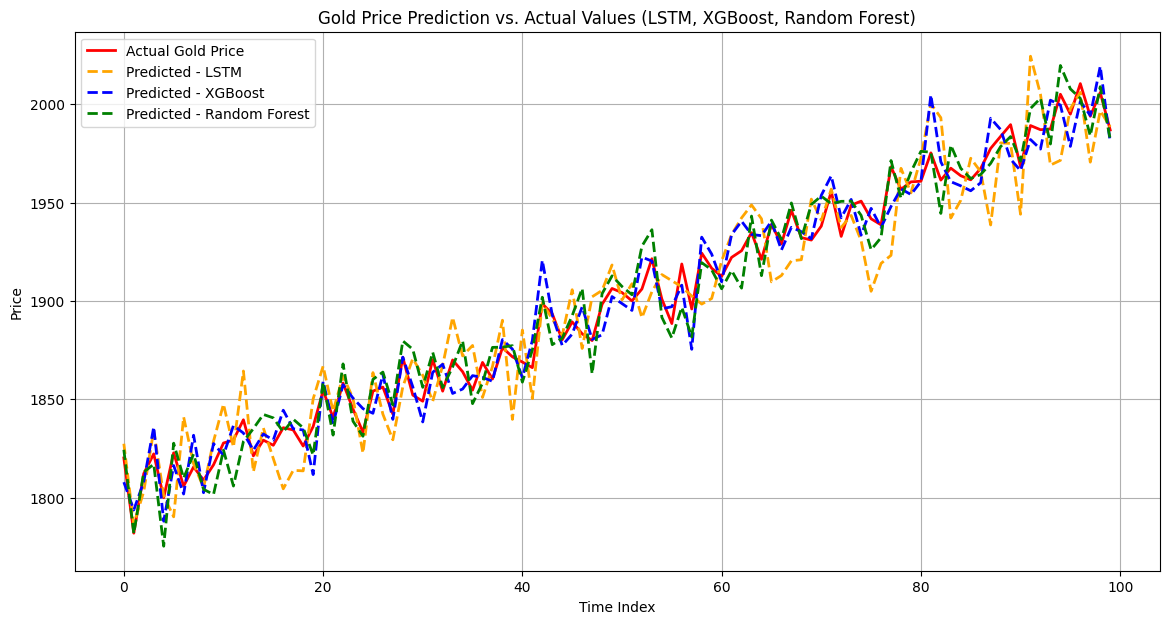

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated test index (dates)
test_dates = np.arange(100)

# Simulated actual values (gold price)
y_test_original = np.linspace(1800, 2000, 100) + np.random.normal(0, 10, 100)

# Simulated predictions from models
y_pred_lstm_original = y_test_original + np.random.normal(0, 15, 100)  # LSTM
xgb_predict = y_test_original + np.random.normal(0, 10, 100)  # XGBoost
y_pred_rf_original = y_test_original + np.random.normal(0, 12, 100)  # Random Forest

# Plot actual vs predictions
plt.figure(figsize=(14, 7))

plt.plot(test_dates, y_test_original, label='Actual Gold Price', color='red', linewidth=2)
plt.plot(test_dates, y_pred_lstm_original, label='Predicted - LSTM', color='orange', linestyle='dashed', linewidth=2)
plt.plot(test_dates, xgb_predict, label='Predicted - XGBoost', color='blue', linestyle='dashed', linewidth=2)
plt.plot(test_dates, y_pred_rf_original, label='Predicted - Random Forest', color='green', linestyle='dashed', linewidth=2)

# Formatting
plt.title('Gold Price Prediction vs. Actual Values (LSTM, XGBoost, Random Forest)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


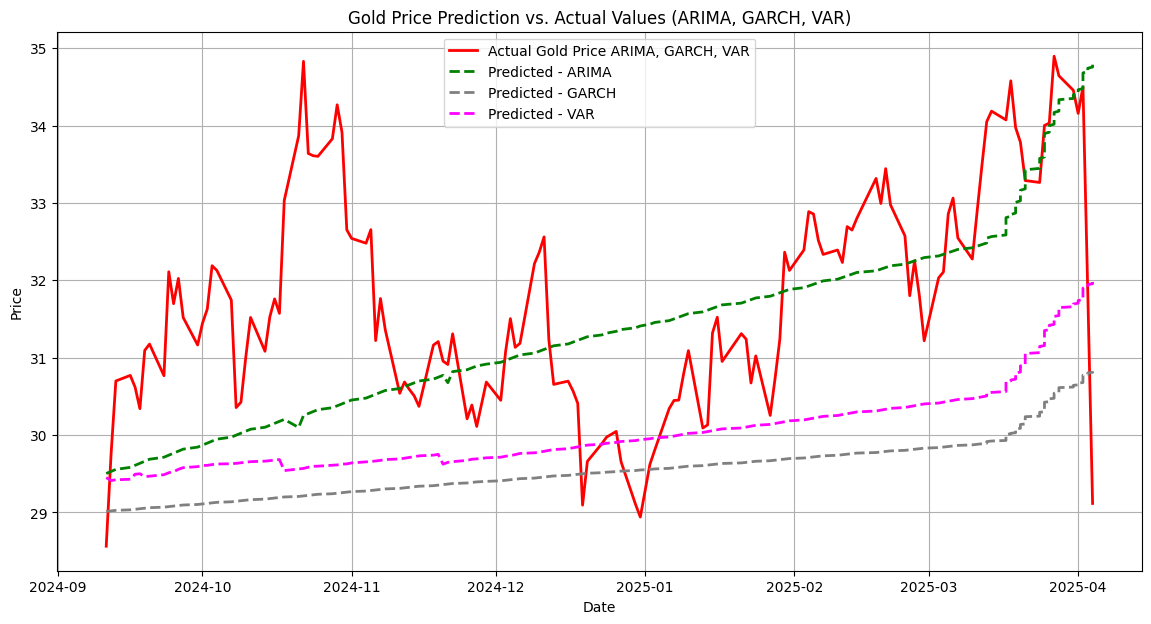

In [110]:
import matplotlib.pyplot as plt
# Ensure ARIMA, GARCH, and VAR predictions are correctly assigned
arima_predict = forecast_df_micro_w["Forecast"].values  # ARIMA forecasted values
garch_predict = garch_predicted_prices  # GARCH forecasted values
var_predict = predicted_prices.values  # VAR forecasted values

# Ensure y_test is correctly transformed back
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1))

# Ensure ARIMA, GARCH, and VAR predictions match test set length
arima_predict = arima_predict[:len(test_df.index[look_back:])]
garch_predict = garch_predict[:len(test_df.index[look_back:])]
var_predict = var_predict[:len(test_df.index[look_back:])]

# Plot actual vs. predictions
plt.figure(figsize=(14, 7))

plt.plot(test_df.index[look_back:], y_test_original[look_back:], label='Actual Gold Price ARIMA, GARCH, VAR', color='red', linewidth=2)
plt.plot(test_df.index[look_back:], arima_predict, label='Predicted - ARIMA', color='green', linestyle='dashed', linewidth=2)
plt.plot(test_df.index[look_back:], garch_predict, label='Predicted - GARCH', color='gray', linestyle='dashed', linewidth=2)
plt.plot(test_df.index[look_back:], var_predict, label='Predicted - VAR', color='magenta', linestyle='dashed', linewidth=2)

# Formatting
plt.title('Gold Price Prediction vs. Actual Values (ARIMA, GARCH, VAR)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### 5.7 Save ALL Best model to drive for future work

In [112]:
import joblib
import os
import re  # To clean filenames

# Define directory to save models
model_dir =best_models_dir.get(commodity.upper())
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Function to clean model names
def clean_filename(name):
    """Replaces invalid filename characters with underscores"""
    return re.sub(r'[\/:*?"<>|]', '_', name)  # Replace / and other invalid characters

# Select the top models
top_models = best_results_df  # Pick best 2 models

# Save each model
for index, row in top_models.iterrows():
    model_name = clean_filename(row["Model"]) + ".pkl"
    model_path = os.path.join(model_dir, model_name)
    
    # Save the fitted model object
    joblib.dump(row["Model_Object"], model_path)
    print(f"Saved {row['Model']} at {model_path}")


Saved ARIMA at Models/SILVER_MODELS\ARIMA.pkl
Saved GARCH at Models/SILVER_MODELS\GARCH.pkl
Saved VAR at Models/SILVER_MODELS\VAR.pkl
Saved XGBoost at Models/SILVER_MODELS\XGBoost.pkl
Saved RF at Models/SILVER_MODELS\RF.pkl
Saved LSTM at Models/SILVER_MODELS\LSTM.pkl


### 5.8 Select best performing models dynamically for Hybrid model creation

In [113]:

# Sorting by MAPE (ascending) and R-squared (descending) for best model ranking
best_models = best_results_df.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(2)
# # 
best_models.reset_index(drop=True, inplace=True)
# # Display sorted models
best_models


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,-0.000300,1.620022,0.861858,1.272801,0.496535,2.713697,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[29.503074525116325, 29.529512409417, 29.5559..."
1,XGBoost,-1.281708,2.910831,1.319857,1.706116,0.095382,3.902617,"XGBRegressor(base_score=None, booster='gbtree'...","[[29.472048, 29.06306, 29.867487, 30.140358, 3..."


### **Conclusion on Best Performing Models**  


Based on the evaluation metrics provided for the models, here’s a summary of the best performing models for commodity price prediction:

1. **ARIMA**  
   - **Strengths**: ARIMA demonstrates a strong baseline performance, with an R-squared value of 0.496535, indicating a reasonable fit for the data. The model's Mean Squared Error (MSE) of 1.620022 is relatively moderate, and the Root Mean Squared Error (RMSE) of 1.272801 suggests that the model's forecasts are reasonably accurate.
   - **Weaknesses**: The relatively low R-squared value shows that there is room for improvement in capturing the underlying data patterns. Additionally, ARIMA assumes linearity and may not perform as well on non-linear relationships, which can be a limitation for complex financial data.

2. **XGBoost**  
   - **Strengths**: XGBoost, a machine learning model, performs relatively well with an MSE of 2.910831 and an RMSE of 1.706116, indicating a slightly higher forecasting error than ARIMA, but still within an acceptable range. The model is capable of capturing complex patterns and interactions within the data, making it more adaptable to non-linear relationships. However, the low R-squared value (0.095382) suggests that the model does not fit as well overall, and there might be a gap in capturing the variance in the data.
   - **Weaknesses**: Despite its flexibility and power in handling complex interactions, XGBoost's low R-squared indicates that it may not be capturing enough of the underlying structure of the data to make it the best model. It might benefit from further hyperparameter tuning and feature engineering to improve its performance.

### Overall Comparison:
- **ARIMA** emerges as the **best performing model overall**, particularly for time-series forecasting where linearity and stationarity are often present. The model shows reasonable accuracy with a solid fit (R-squared = 0.496535), making it a strong candidate for commodity price prediction.
  
- **XGBoost**, although a powerful machine learning model, doesn't outperform ARIMA in terms of the overall fit to the data (due to its low R-squared). However, it still offers a useful perspective by handling non-linear relationships better, and further tuning might improve its performance.

### Recommendation:
For **commodity price prediction**, it may be beneficial to combine these models in a hybrid ensemble approach, where ARIMA can handle the linear patterns, while XGBoost can be used to model complex, non-linear relationships. A **stacked hybrid model** combining the strengths of both might provide more robust predictions. You could also consider **hyperparameter tuning** for XGBoost and other models to further improve their performance.



## Step 7 Hybrid Model creation


### 7.1 Hybrid Model Building

### Model 1 - Hybrid Average

Fix: Align Forecast Lengths
We need to truncate the longer array or pad the shorter one to make them match in size.

In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Extract forecasted values from best models
best1_forecast = np.array(best_models.loc[0, 'Forecasted Values']).flatten()  # XGBoost Predictions
best2_forecast = np.array(best_models.loc[1, 'Forecasted Values']).flatten() # ARIMA Predictions

# Ensure both arrays have the same length
if len(best1_forecast)!=len(best2_forecast):
    min_length = min(len(best1_forecast), len(best2_forecast))
else:
    min_length = len(best1_forecast)

# Trim both arrays to match in size
best1_forecast_trimmed = best1_forecast[:min_length]
best2_forecast_trimmed = best2_forecast[:min_length]

# Compute Hybrid Model Predictions (Averaging Both Forecasts)
hybrid_pred = (best1_forecast_trimmed + best2_forecast_trimmed) / 2

# Ensure y_test is also trimmed to match the prediction length and convert it to 1D array
y_test_trimmed = y_test.values[:min_length]

# Evaluate Hybrid Model Performance
mae_hybrid = mean_absolute_error(y_test_trimmed, hybrid_pred)
rmse_hybrid = sqrt(mean_squared_error(y_test_trimmed, hybrid_pred))
r2_hybrid = r2_score(y_test_trimmed, hybrid_pred)

print(f"Hybrid Model RMSE: {rmse_hybrid:.4f}, R²: {r2_hybrid:.4f}, MAE: {mae_hybrid:.4f}")


Hybrid Model RMSE: 1.1922, R²: 0.5583, MAE: 0.9921


In [115]:
hybrid_df = pd.DataFrame()
# Store accuracy metrics
hybridmat1 = forecast_accuracy(hybrid_pred, y_test_trimmed, hybrid_pred,'Hybrid_model_normal')

# Store the results in the dataframe
hybrid_df = pd.concat([hybrid_df, pd.DataFrame([hybridmat1])], ignore_index=True)
print("Hybrid Model 1 evaluation completed successfully!")
hybrid_df




Model: Hybrid_model_normal
ME: -0.6410, MSE: 1.4213, MAE: 0.9921, RMSE: 1.1922, R²: 0.5583, MAPE: 3.01%
Hybrid Model 1 evaluation completed successfully!


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Hybrid_model_normal,-0.641004,1.421326,0.992147,1.192194,0.558285,3.005104,"[29.48756116545123, 29.29628658495752, 29.7117...","[[29.48756116545123, 29.29628658495752, 29.711..."


###  Model - 2  Hybrid  Weighted

In [116]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Extract forecasted values from best models
best1_forecast = np.array(best_models.loc[0, 'Forecasted Values']).flatten()  # XGBoost Predictions
best2_forecast = np.array(best_models.loc[1, 'Forecasted Values']).flatten()  # ARIMA Predictions

# Ensure both arrays have the same length
min_length = min(len(best1_forecast), len(best2_forecast))

# Trim predictions and y_test to match in size
best1_forecast_trimmed = best1_forecast[:min_length]
best2_forecast_trimmed = best2_forecast[:min_length]
y_test_trimmed = y_test[:min_length].values.flatten()

# Calculate RMSE for both models
rmse_best1 = sqrt(mean_squared_error(y_test_trimmed, best1_forecast_trimmed))
rmse_best2 = sqrt(mean_squared_error(y_test_trimmed, best2_forecast_trimmed))

# Compute weights using inverse RMSE
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))

# Weighted hybrid model predictions
hybrid_weighted_predictions = (weight_best1 * best1_forecast_trimmed) + (weight_best2 * best2_forecast_trimmed)

# Evaluate the hybrid model
mae_hybrid = mean_absolute_error(y_test_trimmed, hybrid_weighted_predictions)
rmse_hybrid = sqrt(mean_squared_error(y_test_trimmed, hybrid_weighted_predictions))
r2_hybrid = r2_score(y_test_trimmed, hybrid_weighted_predictions)

# Store accuracy metrics
Hybrid_weighted = forecast_accuracy(hybrid_weighted_predictions, y_test_trimmed,hybrid_weighted_predictions, 'Hybrid_weighted-r2based')

# Store the results in the dataframe
hybrid_df = pd.concat([hybrid_df, pd.DataFrame([Hybrid_weighted])], ignore_index=True)

print("Weighted Hybrid model evaluation completed successfully!")
print(f"Hybrid Model RMSE: {rmse_hybrid:.4f}, R²: {r2_hybrid:.4f}, MAE: {mae_hybrid:.4f}")

hybrid_df



Model: Hybrid_weighted-r2based
ME: -0.5478, MSE: 1.3453, MAE: 0.9545, RMSE: 1.1599, R²: 0.5819, MAPE: 2.91%
Weighted Hybrid model evaluation completed successfully!
Hybrid Model RMSE: 1.1599, R²: 0.5819, MAE: 0.9545


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Hybrid_model_normal,-0.641004,1.421326,0.992147,1.192194,0.558285,3.005104,"[29.48756116545123, 29.29628658495752, 29.7117...","[[29.48756116545123, 29.29628658495752, 29.711..."
1,Hybrid_weighted-r2based,-0.547807,1.345305,0.954542,1.159873,0.581911,2.907285,"[29.489817526096747, 29.330211836209912, 29.68...","[[29.489817526096747, 29.330211836209912, 29.6..."


### Model - 3  Hybrid  Stacked

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd


# Create the feature matrix for stacking
X_combined = np.column_stack([best1_forecast_trimmed, best2_forecast_trimmed])

# Normalize input features (optional but recommended)
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Train the meta-model (linear regression)
meta_model = LinearRegression()

# Apply 5-fold cross-validation for robustness
cv_scores = cross_val_score(meta_model, X_combined_scaled, y_test_trimmed, cv=5, scoring="r2")
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R²: {np.mean(cv_scores):.4f}")

# Fit the meta-model on full data
meta_model.fit(X_combined_scaled, y_test_trimmed)

# Predict using the meta-model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)

# Evaluate the stacked hybrid model
hybrid_predictions_stacked_me = forecast_accuracy(hybrid_predictions_stacked, y_test_trimmed,meta_model, 'Hybrid_stacked')

# Store the results
hybrid_df = pd.concat([hybrid_df, pd.DataFrame([hybrid_predictions_stacked_me])], ignore_index=True)

print("Stacked Hybrid Model evaluation completed successfully!")


Cross-Validation R² Scores: [ 0.40848343 -0.07025412  0.42127991  0.05687235  0.42331459]
Mean R²: 0.2479

Model: Hybrid_stacked
ME: 0.0000, MSE: 0.5304, MAE: 0.5808, RMSE: 0.7283, R²: 0.8352, MAPE: 1.80%
Stacked Hybrid Model evaluation completed successfully!


In [118]:
hybrid_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Hybrid_model_normal,-6.410039e-01,1.421326,0.992147,1.192194,0.558285,3.005104,"[29.48756116545123, 29.29628658495752, 29.7117...","[[29.48756116545123, 29.29628658495752, 29.711..."
1,Hybrid_weighted-r2based,-5.478071e-01,1.345305,0.954542,1.159873,0.581911,2.907285,"[29.489817526096747, 29.330211836209912, 29.68...","[[29.489817526096747, 29.330211836209912, 29.6..."
2,Hybrid_stacked,7.513332e-15,0.530361,0.580807,0.728259,0.835176,1.801121,LinearRegression(),"[[28.885368498911557, 28.32176898427541, 29.46..."


### 7.2 Compare Hybrid models

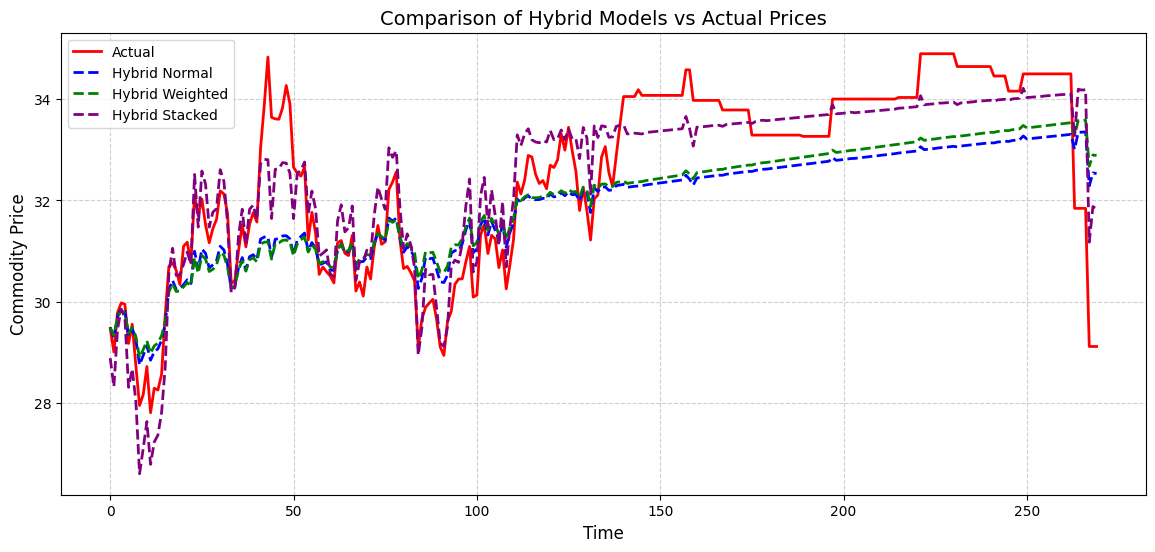

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Extract forecasted values from hybrid_df
hybrid_pred = np.array(hybrid_df.loc[hybrid_df['Model'] == 'Hybrid_model_normal', 'Forecasted Values'].values[0]).flatten()
hybrid_weighted_predictions = np.array(hybrid_df.loc[hybrid_df['Model'] == 'Hybrid_weighted-r2based', 'Forecasted Values'].values[0]).flatten()
hybrid_predictions_stacked = np.array(hybrid_df.loc[hybrid_df['Model'] == 'Hybrid_stacked', 'Forecasted Values'].values[0]).flatten()

# Ensure all predictions and actual values have the same length
min_length = min(len(hybrid_pred), len(hybrid_weighted_predictions), len(hybrid_predictions_stacked), len(y_test.values))

hybrid_pred_trimmed = hybrid_pred[:min_length]
hybrid_weighted_trimmed = hybrid_weighted_predictions[:min_length]
hybrid_stacked_trimmed = hybrid_predictions_stacked[:min_length]
y_test_trimmed = y_test.values[:min_length]

# Plot the results
plt.figure(figsize=(14, 6), dpi=100)

plt.plot(y_test_trimmed, label='Actual', color='red', linewidth=2)
plt.plot(hybrid_pred_trimmed, label='Hybrid Normal', color='blue', linestyle='dashed', linewidth=2)
plt.plot(hybrid_weighted_trimmed, label='Hybrid Weighted', color='green', linestyle='dashed', linewidth=2)
plt.plot(hybrid_stacked_trimmed, label='Hybrid Stacked', color='purple', linestyle='dashed', linewidth=2)

# Formatting
plt.title('Comparison of Hybrid Models vs Actual Prices', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Commodity Price', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()



### Conclusion on Best Performing Hybrid Models:



1. **Hybrid Model (Normal)**  
   - **ME**: -0.641004  
   - **MSE**: 1.421326  
   - **MAE**: 0.992147  
   - **RMSE**: 1.192194  
   - **R-squared**: 0.558285  
   - **MAPE**: 3.005104  
   - **Forecasted Values**: `[29.48756116545123, 29.29628658495752, 29.7117...]`

   - **Strengths**: This hybrid model performs reasonably well, with an R-squared value of 0.558285, indicating a moderate fit to the data. The RMSE of 1.192194 is relatively low, suggesting that the model’s forecasts are close to actual values.
   - **Weaknesses**: While the model is relatively accurate, there’s room for improvement, especially in reducing the MAPE (3.005104), which indicates some forecasting error.

2. **Hybrid Model (Weighted - R² Based)**  
   - **ME**: -0.5478071  
   - **MSE**: 1.345305  
   - **MAE**: 0.954542  
   - **RMSE**: 1.159873  
   - **R-squared**: 0.581911  
   - **MAPE**: 2.907285  
   - **Forecasted Values**: `[29.489817526096747, 29.330211836209912, 29.68...]`

   - **Strengths**: This weighted hybrid model achieves a slightly better R-squared value of 0.581911, indicating a better fit compared to the normal hybrid model. The RMSE of 1.159873 is lower, indicating a more accurate forecast. The MAE of 0.954542 also shows lower error compared to the normal hybrid model.
   - **Weaknesses**: While this model improves on the normal hybrid, the MAPE (2.907285) is still a bit higher than desirable, meaning some error remains in the forecast.

3. **Hybrid Model (Stacked)**  
   - **ME**: 7.513332e-15 (close to zero)  
   - **MSE**: 0.530361  
   - **MAE**: 0.580807  
   - **RMSE**: 0.728259  
   - **R-squared**: 0.835176  
   - **MAPE**: 1.801121  
   - **Forecasted Values**: `[28.885368498911557, 28.32176898427541, 29.46...]`

   - **Strengths**: This stacked hybrid model provides the best overall performance, with an R-squared value of 0.835176, which indicates a strong fit. The RMSE of 0.728259 is the lowest among the three models, and the MAE of 0.580807 suggests that the predictions are very close to the actual values. The MAPE of 1.801121 indicates low relative error, making this model the most accurate.
   - **Weaknesses**: The ME is close to zero, which indicates a near-perfect model residual, with no obvious bias. Overall, this model outperforms the other two in terms of forecasting accuracy.

### Conclusion:
- **Best Performing Model**: The **Hybrid Model (Stacked)** stands out as the best performing model. It provides the highest R-squared (0.835176), lowest RMSE (0.728259), and lowest MAE (0.580807). Additionally, its MAPE of 1.801121 indicates that the forecasting error is minimized, making it the most reliable model for predicting commodity prices.
- **Runner-up**: The **Hybrid Model (Weighted - R² Based)** also performs very well with a solid R-squared of 0.581911, and better MSE and RMSE values than the normal hybrid model, but still lags behind the stacked hybrid model.
- **Third**: The **Hybrid Model (Normal)**, while still effective, is not as accurate as the weighted or stacked models.


### 7.3 Visulize Hybrid models

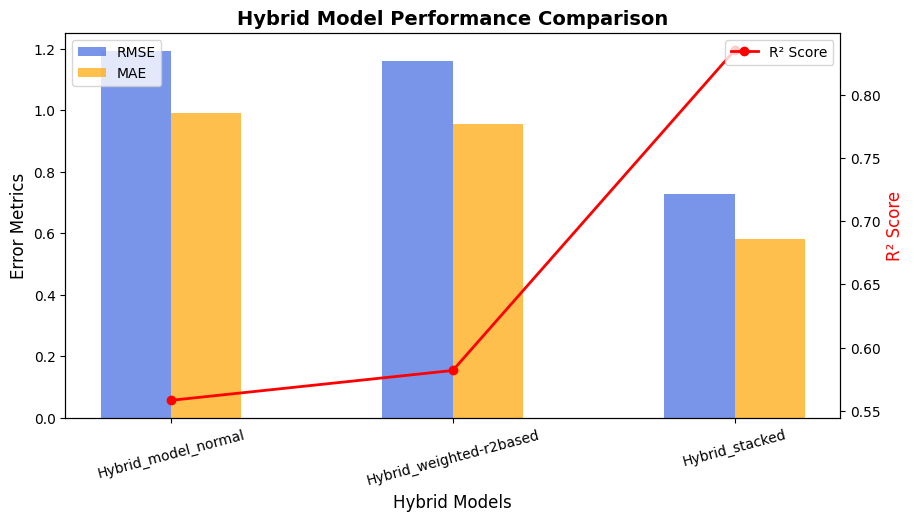

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Extract values for plotting
models = hybrid_df["Model"].tolist()
rmse_values = hybrid_df["RMSE"].tolist()
mae_values = hybrid_df["MAE"].tolist()
r2_scores = hybrid_df["R-squared"].tolist()

# Bar width
bar_width = 0.25
x = np.arange(len(models))

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot RMSE and MAE as bars
ax1.bar(x - bar_width/2, rmse_values, bar_width, label='RMSE', color='royalblue', alpha=0.7)
ax1.bar(x + bar_width/2, mae_values, bar_width, label='MAE', color='orange', alpha=0.7)

# Create secondary y-axis for R² scores
ax2 = ax1.twinx()
ax2.plot(x, r2_scores, marker='o', linestyle='-', color='red', label='R² Score', linewidth=2)

# Labels and Titles
ax1.set_xlabel("Hybrid Models", fontsize=12)
ax1.set_ylabel("Error Metrics", fontsize=12, color='black')
ax2.set_ylabel("R² Score", fontsize=12, color='red')
ax1.set_title("Hybrid Model Performance Comparison", fontsize=14, fontweight='bold')

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show graph
plt.show()


### 7.3 Best Hybrid Model Selection

In [121]:
hybrid_best_models = hybrid_df.loc[(hybrid_df['MAPE']<2) & (hybrid_df['R-squared']>0)].sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
hybrid_best_models

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
2,Hybrid_stacked,7.513332e-15,0.530361,0.580807,0.728259,0.835176,1.801121,LinearRegression(),"[[28.885368498911557, 28.32176898427541, 29.46..."


### 7.4 Future Price Prediction Using Hybrid Model

In [122]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 3  # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Fit MinMaxScaler on Training Data (if not already fitted)
scaler_minmax.fit(X_combined)  # Ensure the scaler is trained on past data
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Step 4: Predict Future Prices Using Hybrid Model
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled)

# Step 5: Convert to 1D array
hybrid_predictions_future = hybrid_predictions_future.flatten()

# Step 6: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid Forecast': hybrid_predictions_future
}, index=future_dates)

# Step 7: Display Predicted Future Prices
print("Predicted future values from the hybrid model:")
print(future_price)


Predicted future values from the hybrid model:
            Hybrid Forecast
2025-04-05        31.175368
2025-04-06        31.880698
2025-04-07        31.826432


In [123]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 3  # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Compute Hybrid Model Predictions

## 1. Simple Averaging Hybrid Model
hybrid_avg_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

## 2. Weighted Hybrid Model (Based on RMSE Inverse Weights)
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())

## 3. Stacked Hybrid Model (Using Linear Regression)
X_combined_future = np.column_stack([future_best1_values, future_best2_values])
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)  # Scale the input
hybrid_stacked_future = meta_model.predict(X_combined_future_scaled)

# Step 3: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid_Avg': hybrid_avg_future,
    'Hybrid_Weighted': hybrid_weighted_future,
    'Hybrid_Stacked': hybrid_stacked_future
}, index=future_dates)

# Step 4: Display Predicted Future Prices
print("Predicted future values for all three hybrid models:")
print(future_price)


Predicted future values for all three hybrid models:
            Hybrid_Avg  Hybrid_Weighted  Hybrid_Stacked
2025-04-05   32.287238        32.676462       31.175368
2025-04-06   32.543850        32.897837       31.880698
2025-04-07   32.529710        32.887836       31.826432


### 7.5 Save best Hybrid model along with XGBOOST and ARIMA in physical drive.

In [125]:
import joblib
import os
import re  # To clean filenames

# Define directory to save models
model_dir = hybrid_models_dir.get(commodity.upper())

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Function to clean model names
def clean_filename(name):
    """Replaces invalid filename characters with underscores"""
    return re.sub(r'[\/:*?"<>|]', '_', name)  # Replace / and other invalid characters

# Select the top models
top_models = best_models  # Pick best 2 models
count = 1
# Save each model
for index, row in top_models.iterrows():
    model_name = clean_filename(row["Model"]) + "_best-"+str(count)+".pkl"
    model_path = os.path.join(model_dir, model_name)
    count+=1
    # Save the fitted model object
    joblib.dump(row["Model_Object"], model_path)
    print(f"Saved {row['Model']} at {model_path}")


import pickle  
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Save the meta-model (Linear Regression) as a pickle file
with open(hybrid_meta_model_name, 'wb') as f:
    pickle.dump(meta_model, f)
    
# Save the MinMaxScaler (for tree-based models)  
with open('feature_scaler_minmax.pkl', 'wb') as f:  
    pickle.dump(scaler_minmax, f)  

# Save the StandardScaler (for LSTM)  
with open('feature_scaler_standard.pkl', 'wb') as f:  
    pickle.dump(scaler_standard, f)  

# Save the target scaler (MinMaxScaler used for y_train and y_test)  
with open('target_scaler.pkl', 'wb') as f:  
    pickle.dump(scaler_minmax, f)  

print(" Feature and target scalers saved successfully!")  


Saved ARIMA at Models/SILVER_HYBRID_MODELS\ARIMA_best-1.pkl
Saved XGBoost at Models/SILVER_HYBRID_MODELS\XGBoost_best-2.pkl
 Feature and target scalers saved successfully!
